# Bareinboim Inequalities for MIMIC

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.stats import rankdata
import matplotlib.pyplot as plt
exportdir='/data/localhost/taufiq/export-dir/'

In [2]:
import logging
logging.basicConfig(filename='hoeff.log', level=logging.INFO)

In [4]:
nra = 5
nr_reps = 1
col_bins_num = 5
use_semisynthetic_obs = False

In [5]:
MIMICtable = pd.read_csv(exportdir + '/MIMIC-1hourly-length-5-filtered.csv')
MIMIC_generated_males = pd.read_csv(exportdir + '/MIMIC-generated-length-5-gender-0.0.csv')
MIMIC_generated_females = pd.read_csv(exportdir + '/MIMIC-generated-length-5-gender-1.0.csv')
MIMICtable = pd.concat([MIMICtable, MIMIC_generated_males, MIMIC_generated_females], ignore_index=True)

In [6]:
if use_semisynthetic_obs:
    observational_data = MIMICtable.copy()
else:
    MIMICtable_combined = pd.read_csv(exportdir + '/MIMIC-1hourly-length-5-combined.csv')
    observational_data = MIMICtable_combined.copy()

In [7]:
len(observational_data)/5

11677.0

In [8]:
age_ranked = rankdata(observational_data['age'])/len(observational_data)
age_bins = np.floor((age_ranked + 0.2499999999)*4)
median_ages = [observational_data.loc[age_bins==1, 'age'].median(), observational_data.loc[age_bins==2, 'age'].median(), observational_data.loc[age_bins==3, 'age'].median(), observational_data.loc[age_bins==4, 'age'].median()]
observational_data = observational_data.rename(columns={"age": "age_raw"})
observational_data['age'] = age_bins


In [9]:
age_ranked = rankdata(MIMICtable['age'])/len(MIMICtable)
age_bins = np.floor((age_ranked + 0.2499999999)*4)
median_ages = [MIMICtable.loc[age_bins==1, 'age'].median(), MIMICtable.loc[age_bins==2, 'age'].median(), MIMICtable.loc[age_bins==3, 'age'].median(), MIMICtable.loc[age_bins==4, 'age'].median()]
MIMICtable = MIMICtable.rename(columns={"age": "age_raw"})
MIMICtable['age'] = age_bins

In [10]:
import os
import glob
os.chdir("/data/localhost/taufiq/pulse-data-5-step")
extension = 'final_.csv'
all_filenames = [i for i in glob.glob('*{}'.format(extension))]
all_filenames = all_filenames + [i for i in glob.glob('./synthetic_data/*{}'.format(extension))]
pulse_data = pd.concat([pd.read_csv(f) for f in all_filenames ])
pulse_data = pulse_data.rename(columns={'id': 'icustay_id'})
pulse_data['icustay_id'] = pulse_data['icustay_id'].astype(int)
pulse_data = pulse_data.reset_index(drop=True)
pulse_data = pulse_data.sort_values(by=['icustay_id', 'SimulationTime(s)'], ignore_index=True)
pulse_data['bloc'] = np.arange(len(pulse_data))%5 + 1
pulse_data.head()

,Albumin - BloodConcentration (mg/L),ArterialCarbonDioxidePressure (mmHg),ArterialOxygenPressure (mmHg),ArterialPressure (mmHg),Bicarbonate - BloodConcentration (mg/L),BloodPH (None),BloodUreaNitrogenConcentration (mg/dL),BloodVolume (mL),Calcium - BloodConcentration (mg/L),CarbonDioxideSaturation (None),...,RespirationRate (1/min),SaturationAndFractionOfInspiredOxygenRatio (None),SimulationTime(s),SkinTemperature (degC),Sodium - BloodConcentration (mg/L),SystolicArterialPressure (mmHg),WhiteBloodCellCount (ct/uL),icustay_id,time,bloc
0,36971.911153,40.121759,90.942581,88.417880,1590.189288,7.412477,13.036798,4640.620191,48.207067,0.028632,...,20.134228,4.646044,0.0,33.130515,3327.522356,119.898164,7000.0,3,7.245400e+09,1
1,35899.080416,40.295497,92.240242,92.028320,1590.361120,7.410769,15.109420,4769.504190,54.298146,0.028445,...,20.833333,4.645351,3600.0,32.814843,3316.814960,121.301612,7000.0,3,7.245403e+09,2
2,34887.421594,40.313523,92.215037,106.015304,1590.284502,7.410592,20.730085,4897.953845,60.775848,0.028452,...,20.833333,4.645612,7200.0,32.533793,3307.756345,123.275558,7000.0,3,7.245407e+09,3
3,33927.979505,40.325572,92.262822,103.367986,1590.257833,7.410474,25.855462,5026.549368,66.898886,0.028449,...,20.833333,4.645723,10800.0,32.765652,3302.748443,125.600846,7000.0,3,7.245410e+09,4
4,33088.536551,40.305062,92.327881,71.410965,1589.972682,7.410675,30.823689,5144.112833,72.855658,0.028455,...,20.833333,4.646063,14400.0,32.834440,3277.230920,126.459716,7000.0,3,7.245414e+09,5


In [11]:
len(pulse_data)/5

14610.0

In [12]:
column_mappings = {
    'Albumin - BloodConcentration (mg/L)': 'Albumin',
    'ArterialCarbonDioxidePressure (mmHg)': 'paCO2',
    'ArterialOxygenPressure (mmHg)': 'paO2',
    'Bicarbonate - BloodConcentration (mg/L)': 'HCO3',
    'BloodPH (None)': 'Arterial_pH',
    'Calcium - BloodConcentration (mg/L)': 'Calcium',
    'Chloride - BloodConcentration (mg/L)': 'Chloride',
    'Creatinine - BloodConcentration (mg/L)': 'Creatinine',
    'DiastolicArterialPressure (mmHg)': 'DiaBP',
    'Glucose - BloodConcentration (mg/L)': 'Glucose',
    'Lactate - BloodConcentration (mg/L)': 'Arterial_lactate',
    'MeanArterialPressure (mmHg)': 'MeanBP',
    'Potassium - BloodConcentration (mg/L)': 'Potassium',
    'RespirationRate (1/min)': 'RR',
    'SkinTemperature (degC)': 'Temp_C',
    'Sodium - BloodConcentration (mg/L)': 'Sodium',
    'SystolicArterialPressure (mmHg)': 'SysBP',
    'WhiteBloodCellCount (ct/uL)': 'WBC_count',
    'HeartRate (1/min)': 'HR'
}

pulse_rename = {}

for k, v in column_mappings.items():
    pulse_rename.update({k: f"{v}"})

sim_data = pulse_data.rename(columns=pulse_rename)

sim_data = sim_data.merge(MIMICtable[['gender', 'age', 'Weight_kg', 'icustay_id', 'bloc']], left_on=['icustay_id', 'bloc'], right_on=['icustay_id', 'bloc'])

sim_data.head()

,Albumin,paCO2,paO2,ArterialPressure (mmHg),HCO3,Arterial_pH,BloodUreaNitrogenConcentration (mg/dL),BloodVolume (mL),Calcium,CarbonDioxideSaturation (None),...,Temp_C,Sodium,SysBP,WBC_count,icustay_id,time,bloc,gender,age,Weight_kg
0,36956.148921,38.963593,91.699266,109.970415,1588.920899,7.424054,13.099385,5142.230283,48.184907,0.029009,...,33.112334,3325.983809,115.313637,7000.0,14,4.264269e+09,1,0.0,4.0,73.300003
1,35393.986455,39.348167,92.657544,115.301997,1589.009926,7.420172,15.401907,5358.294397,52.868259,0.028744,...,32.445347,3315.232842,117.565700,7000.0,14,4.264273e+09,2,0.0,4.0,71.800000
2,28799.488674,39.204086,92.999155,55.596113,1588.457784,7.421622,17.884865,6573.488118,48.969245,0.028816,...,32.653264,3306.962520,135.506687,7000.0,14,4.264276e+09,3,0.0,4.0,71.800000
3,28137.774189,39.340030,93.043224,131.119564,1588.152799,7.420254,22.939166,6717.344511,53.651599,0.028764,...,33.029873,3307.121266,138.081243,7000.0,14,4.264280e+09,4,0.0,4.0,71.800000
4,27762.117998,39.349305,93.040334,124.141909,1588.063797,7.420161,27.589372,6797.503106,58.658890,0.028759,...,32.982227,3281.155130,134.524102,7000.0,14,4.264284e+09,5,0.0,4.0,71.800000


In [13]:
import matplotlib.pyplot as plt

column_names_unit = {
    'Albumin': 'Albumin Blood Concentration (mg/L)',
#     'paCO2': 'Arterial $CO_2$ Pressure (mmHg)',
#     'paO2': 'Arterial $O_2$ Pressure (mmHg)',
#     'HCO3': 'Bicarbonate Blood Concentration (mg/L)',
    'Arterial_pH': 'Arterial pH',
    'Arterial_lactate': 'Lactate Blood Concentration (mg/L)',
    'Calcium': 'Calcium Blood Concentration (mg/L)',
    'Chloride': 'Chloride Blood Concentration (mg/L)',
    'Creatinine': 'Creatinine Blood Concentration (mg/L)',
    'DiaBP': 'Diastolic Arterial Pressure (mmHg)',
    'SysBP': 'Systolic Arterial Pressure (mmHg)',
    'Glucose': 'Glucose Blood Concentration (mg/L)',
    'MeanBP': 'Mean Arterial Pressure (mmHg)',
    'Potassium': 'Potassium Blood Concentration (mg/L)',
    'RR': 'Respiration Rate (1/min)',
    'Temp_C': 'Skin Temperature (C)',
    'Sodium': 'Sodium Blood Concentration (mg/L)',
    'WBC_count': 'White Blood Cell Count (ct/uL)',
    'HR': 'Heart Rate (1/min)'
}

In [14]:
column_names_dict = {
    'Albumin': 'Albumin Blood Concentration',
    'paCO2': 'Arterial $CO_2$ Pressure',
    'paO2': 'Arterial $O_2$ Pressure',
    'HCO3': 'Bicarbonate Blood Concentration',
    'Arterial_pH': 'Arterial pH',
    'Arterial_lactate': 'Lactate Blood Concentration',
    'Calcium': 'Calcium Blood Concentration',
    'Chloride': 'Chloride Blood Concentration',
    'Creatinine': 'Creatinine Blood Concentration',
    'DiaBP': 'Diastolic Arterial Pressure',
    'SysBP': 'Systolic Arterial Pressure',
    'Glucose': 'Glucose Blood Concentration',
    'MeanBP': 'Mean Arterial Pressure',
    'Potassium': 'Potassium Blood Concentration',
    'RR': 'Respiration Rate',
    'Temp_C': 'Skin Temperature',
    'Sodium': 'Sodium Blood Concentration',
    'WBC_count': 'White Blood Cell Count',
    'HR': 'Heart Rate'
}

In [1239]:
l = [1,2,3,4]
l[:3]

[1, 2, 3]

In [166]:
hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/cts_outcome_2bins_yminmax_8020quantiles_d0_splitting_t5_pruning/perc/"

data = {'columns':[], 'total_hypotheses':[], 'rejected_hypotheses': [], 'percentage_of_rejected_hyp': []}
p_vals = pd.DataFrame()
for col in tqdm(column_names_dict):
    if os.path.exists(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv"):
        p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval})
        if len(p_values)>0:
            p_values = p_values.loc[p_values['t']>0]
            p_values['col'] = col
            p_vals = pd.concat([p_vals, p_values], axis=0)
        
for col in tqdm(column_names_dict):
    if os.path.exists(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv"):
        p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval})
        if len(p_values)>0:
            p_values = p_values.loc[p_values['t']>0]
            p_values['col'] = col
            rej_hyps = p_values[(p_values['p_ub'] < 0.05/4/len(p_vals)) | (p_values['p_lb'] < 0.05/4/len(p_vals))]
            data['columns'].append(col)
            data['total_hypotheses'].append(len(p_values))
            data['rejected_hypotheses'].append(len(rej_hyps))
            data['percentage_of_rejected_hyp'].append(len(rej_hyps)/len(p_values)*100)


results_bootstrapping = pd.DataFrame(data)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.25it/s]


In [163]:
hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/cts_outcome_2bins_yminmax_8020quantiles_d0_splitting_t5_pruning/hoeff/"

data = {'columns':[], 'total_hypotheses':[], 'rejected_hypotheses': [], 'percentage_of_rejected_hyp': []}
p_vals = pd.DataFrame()

for col in tqdm(column_names_dict):
    if os.path.exists(f"{hyp_test_dir}/p_values_{col}_hoeffTrue.csv"):
        p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffTrue.csv", converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval})
        if len(p_values)>0:
            p_values = p_values.loc[p_values['t'] > 0]
            p_values['col'] = col
            p_values['p_lb'] = p_values['p_lb'].clip(0,1)
            p_values['p_ub'] = p_values['p_ub'].clip(0,1)
            p_vals = pd.concat([p_vals, p_values], axis=0)        


for col in tqdm(column_names_dict):
    if os.path.exists(f"{hyp_test_dir}/p_values_{col}_hoeffTrue.csv"):
        p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffTrue.csv", converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval})
        if len(p_values)>0:
            p_values = p_values.loc[p_values['t'] > 0]
            p_values['col'] = col
            p_values['p_lb'] = p_values['p_lb'].clip(0,1)
            p_values['p_ub'] = p_values['p_ub'].clip(0,1)
            rej_hyps = p_values[(p_values['p_ub'] < 0.05/4/len(p_vals)) | (p_values['p_lb'] < 0.05/4/len(p_vals))]
            rej_hyps = rej_hyps.loc[rej_hyps['t']>0]
            data['columns'].append(col)
            data['total_hypotheses'].append(len(p_values))
            data['rejected_hypotheses'].append(len(rej_hyps))
            data['percentage_of_rejected_hyp'].append(len(rej_hyps)/len(p_values)*100)

results_hoeff = pd.DataFrame(data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 127.80it/s]


In [1251]:
# t = p_vals[(p_vals['p_ub'] < 0.05/4) | (p_vals['p_lb'] < 0.05/4)]
p_values

,Unnamed: 0,gender,age,actions,x_t,p_lb,p_ub,Y_lb_mean,Y_ub_mean,Exp_y,Sim_exp_y,t,n_obs,n_obs_with_actions_of_interest,y_lo,y_up,n_sim,n_sim_w_pruning,col
0,0,0.0,1.0,"(5,)","(0.0,)",1.000000,1.0,73.051247,85.680102,78.295598,75.775304,1,655,49,72.75,86.40,16,16,HR
1,1,0.0,4.0,"(7,)","(0.0,)",1.000000,1.0,66.910707,82.569293,73.877068,69.347986,1,764,80,66.24,83.73,25,25,HR
2,2,0.0,2.0,"(3,)","(1.0,)",1.000000,1.0,92.360862,104.734496,97.821460,97.883944,1,842,390,88.15,111.20,201,201,HR
3,3,0.0,2.0,"(5,)","(0.0,)",1.000000,1.0,71.475914,85.543213,77.186318,74.406477,1,844,68,71.00,86.30,32,32,HR
4,4,1.0,4.0,"(5,)","(1.0,)",1.000000,1.0,86.505985,106.197336,96.492914,95.118855,1,659,61,85.50,107.20,39,39,HR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,278,0.0,3.0,"(3, 3, 3, 3)","(1.0, 1.0, 0.0, 0.0)",1.000000,1.0,79.907870,105.733102,94.119996,79.916462,4,432,11,79.80,106.30,11,11,HR
279,279,1.0,2.0,"(4, 4, 4, 4)","(1.0, 1.0, 1.0, 1.0)",1.000000,1.0,84.540496,100.710530,93.942071,90.978274,4,594,29,84.00,101.00,11,11,HR
280,280,1.0,4.0,"(5, 5, 5, 5)","(0.0, 0.0, 0.0, 0.0)",1.000000,1.0,65.272024,82.308477,73.402537,65.751804,4,812,26,65.00,82.60,15,15,HR
281,281,1.0,4.0,"(3, 3, 3, 3)","(1.0, 1.0, 0.0, 0.0)",3.999220,1.0,84.169256,109.307848,95.249038,84.100000,4,412,9,84.10,109.80,20,20,HR


In [164]:
results_hoeff

,columns,total_hypotheses,rejected_hypotheses,percentage_of_rejected_hyp
0,paCO2,187,0,0.0
1,paO2,191,0,0.0
2,HCO3,183,0,0.0
3,Arterial_pH,197,0,0.0
4,Chloride,15,0,0.0
5,DiaBP,160,0,0.0
6,SysBP,230,0,0.0
7,Glucose,154,0,0.0
8,MeanBP,143,0,0.0
9,Potassium,66,0,0.0


In [167]:
results_bootstrapping

,columns,total_hypotheses,rejected_hypotheses,percentage_of_rejected_hyp
0,paCO2,187,12,6.417112
1,paO2,191,7,3.664921
2,HCO3,183,8,4.371585
3,Arterial_pH,197,0,0.000000
4,Chloride,15,6,40.000000
5,DiaBP,160,0,0.000000
6,SysBP,230,7,3.043478
7,Glucose,154,10,6.493506
8,MeanBP,143,1,0.699301
9,Potassium,66,15,22.727273


Text(0.5, 0, '$p_{up}$')

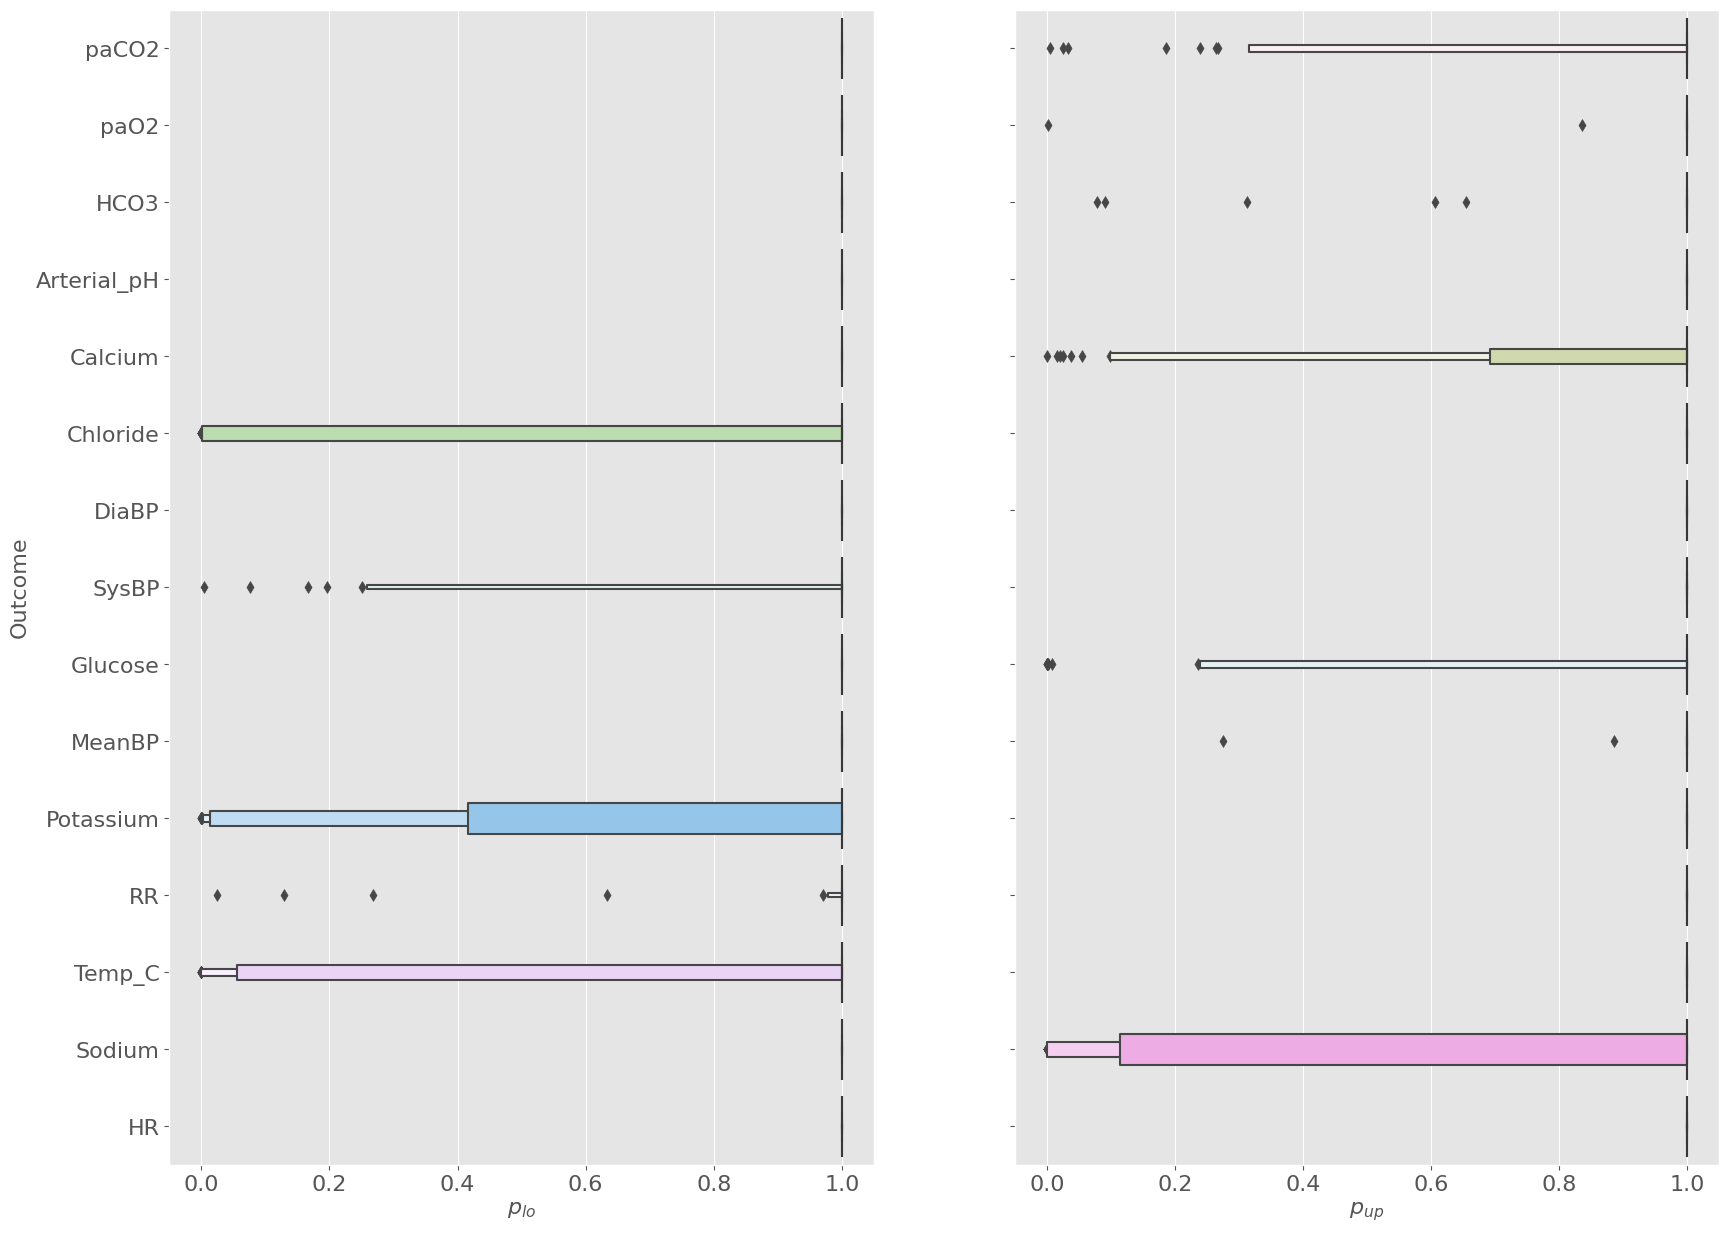

In [148]:
import seaborn as sns

plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(20,15), sharey=True)
ax = sns.boxenplot(x='p_lb', y='col', data=p_vals, ax=axs[0] )
ax = sns.boxenplot(x='p_ub', y='col', data=p_vals, ax=axs[1] )
# axs[0].set_yticks(ticks=list(p_vals['col'].unique()), fontsize=14)
axs[0].tick_params(axis='y', labelsize=16)
axs[0].tick_params(axis='x', labelsize=16)
axs[1].tick_params(axis='x', labelsize=16)
axs[0].set_ylabel('Outcome', fontsize=16)
axs[1].set_ylabel('', fontsize=16)
axs[0].set_xlabel('$p_{lo}$', fontsize=16)
axs[1].set_xlabel('$p_{up}$', fontsize=16)


In [1035]:
p_vals[p_vals['col']=='Chloride']

,Unnamed: 0,gender,age,actions,x_t,p_lb,p_ub,Y_lb_mean,Y_ub_mean,Sim_exp_y,Exp_y,y_lo,y_up,t,n_obs,n_sim_before_pruning,n_sim,col
8,8,0.0,1.0,"(5,)","(1.0,)",0.01,1.0,"[3556.0273735489204, 3559.0770729684905, 3557....","[3823.563070066299, 3820.05194859035, 3826.656...","[3545.0, 3545.0, 3545.0, 3545.0, 3545.0, 3545....","[3671.6572619047606, 3673.613257575755, 3697.1...",3545.00,3838.05,1,804,65,65,Chloride
9,9,0.0,4.0,"(7,)","(1.0,)",0.01,1.0,"[3528.8453211516776, 3528.794285714245, 3532.0...","[3849.1319490587043, 3850.2350996677847, 3848....","[3516.640000000001, 3516.640000000001, 3516.64...","[3672.9719858156027, 3679.237333333333, 3687.9...",3516.64,3864.05,1,602,40,40,Chloride
10,10,0.0,2.0,"(3,)","(1.0,)",0.01,1.0,"[3589.714664790446, 3594.008543909016, 3586.90...","[3727.5757759015437, 3726.856523706984, 3733.7...","[3509.550000000021, 3509.550000000021, 3509.55...","[3665.54610445713, 3668.436381890631, 3669.930...",3509.55,3793.15,1,792,318,318,Chloride
11,11,0.0,2.0,"(5,)","(1.0,)",0.01,1.0,"[3491.9139585947787, 3493.411428272737, 3490.4...","[3804.1586260979184, 3807.880060644133, 3807.5...","[3474.1000000000035, 3474.1000000000035, 3474....","[3623.5497368421034, 3645.113425925925, 3628.9...",3474.10,3828.60,1,797,68,68,Chloride
12,12,1.0,4.0,"(5,)","(1.0,)",0.01,1.0,"[3410.290000000025, 3410.290000000025, 3410.29...","[3879.80354515052, 3880.5900000000183, 3879.80...","[3410.2900000000013, 3410.2900000000013, 3410....","[3410.29, nan, 3410.29, nan, nan, 3410.29, 341...",3410.29,3880.59,1,598,65,65,Chloride
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,163,0.0,1.0,"(3, 3, 3)","(1.0, 1.0, 0.0)",1.00,1.0,"[3438.649999999975, 3438.649999999975, 3438.64...","[3790.9706967212805, 3791.69713114751, 3791.69...","[3438.649999999998, 3438.649999999998, 3438.64...","[3438.65, 3438.65, 3438.65, 3438.65, 3438.65, ...",3438.65,3793.15,3,488,36,36,Chloride
164,164,0.0,4.0,"(2, 2, 2)","(1.0, 1.0, 0.0)",0.23,1.0,"[3438.8992091388054, 3438.6499999999655, 3438....","[3940.5198242531014, 3942.040000000026, 3941.2...","[3438.650000000001, 3438.650000000001, 3438.65...","[3509.55, nan, 3509.55, 3509.55, 3509.55, 3509...",3438.65,3942.04,3,569,13,13,Chloride
165,165,0.0,1.0,"(3, 3, 2)","(1.0, 1.0, 1.0)",1.00,1.0,"[3580.4500000000207, 3580.4500000000207, 3580....","[3828.600000000054, 3828.600000000054, 3828.60...","[3580.4499999999994, 3580.4499999999994, 3580....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",3580.45,3828.60,3,774,14,14,Chloride
166,166,0.0,4.0,"(3, 3, 3)","(1.0, 1.0, 0.0)",0.23,1.0,"[3453.353693181812, 3453.0918465909035, 3452.8...","[3904.5355113636474, 3905.5627556818295, 3906....","[3452.8300000000013, 3452.8300000000013, 3452....","[3545.0000000000005, 3545.0000000000005, nan, ...",3452.83,3906.59,3,352,22,22,Chloride


# Save histogram plots

In [65]:
hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/cts_outcome_2bins_yminmax_8020quantiles_d0_splitting_t5/perc"

data = {'columns':[], 'total_hypotheses':[], 'rejected_hypotheses': [], 'percentage_of_rejected_hyp': []}
p_vals = pd.DataFrame()
for col in tqdm(column_names_dict):
    if os.path.exists(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv"):
        p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval, 'yobs_values': eval, 'ysim_values': eval})
        p_values['col'] = col
        p_values['Exp_y'] = p_values['Exp_y'].apply(lambda val: eval(val) if 'nan' not in val else [])
        p_vals = pd.concat([p_vals, p_values], axis=0)
        rej_hyps = p_values[(p_values['p_ub'] < 0.05/4) | (p_values['p_lb'] < 0.05/4)]
        data['columns'].append(col)
        data['total_hypotheses'].append(len(p_values))
        data['rejected_hypotheses'].append(len(rej_hyps))
        data['percentage_of_rejected_hyp'].append(len(rej_hyps)/len(p_values)*100)

results_bootstrapping = pd.DataFrame(data)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.70it/s]


In [19]:
p_vals

,Unnamed: 0,gender,age,actions,x_t,p_lb,p_ub,Y_lb_mean,Y_ub_mean,Sim_exp_y,Exp_y,y_lo,y_up,yobs_values,ysim_values,t,n_obs,n_sim_before_pruning,n_sim,col
0,0,0.0,1.0,"(5,)","(0.0,)",1.000,1.000,"[30.65989847715736, 30.676395939086294, 30.517...","[40.71065989847716, 40.755076142131976, 40.693...","[40.44784205082069, 40.356268149606514, 40.461...","[37.64705882352941, 38.07575757575758, 36.9096...",30.0,41.0,"[31.0, 35.0, 40.0, 41.0, 41.0, 30.0, 35.0, 41....","[40.2954970866787, 40.3538380623767, 40.557869...",1,788,65,65,paCO2
1,1,0.0,4.0,"(7,)","(0.0,)",1.000,1.000,"[35.30606060606061, 35.25616509926855, 35.2318...","[41.00386624869418, 40.99409613375165, 41.0199...","[40.208923505369526, 40.21861369455585, 40.271...","[37.78952380952382, 37.476262626262624, 37.425...",35.0,41.4,"[41.4, 35.0, 41.0, 35.0, 41.0, 35.0, 38.0, 38....","[39.34816726307192, 40.01120367472443, 40.4433...",1,638,40,40,paCO2
2,2,0.0,2.0,"(3,)","(0.0,)",1.000,0.000,"[33.64996351346184, 33.83446569625303, 33.9255...","[39.222587087606136, 39.419256570777506, 39.43...","[40.27111614979207, 40.276476308069284, 40.306...","[36.763206078916014, 37.22058616467705, 37.330...",31.4,41.0,"[31.4, 40.0, 32.0, 41.0, 37.0, 40.0, 31.4, 34....","[39.697210527996745, 39.45815307064623, 40.468...",1,789,318,318,paCO2
3,3,0.0,2.0,"(5,)","(0.0,)",1.000,1.000,"[31.95682298267883, 31.94592310942154, 32.0209...","[40.729446556822985, 40.66987748204479, 40.696...","[40.34364525926397, 40.40454941433276, 40.3154...","[37.860784313725496, 37.38240740740741, 37.846...",31.4,41.0,"[41.0, 41.0, 31.4, 41.0, 41.0, 41.0, 40.0, 39....","[40.21329428098759, 39.54045626919882, 40.9460...",1,789,68,68,paCO2
4,4,1.0,4.0,"(5,)","(0.0,)",1.000,0.939,"[32.253481288076195, 32.203176675369484, 32.12...","[39.80909486510054, 39.945213228895156, 39.951...","[39.76988645923736, 39.82779974495409, 39.7825...","[36.311255411255395, 36.94722222222223, 36.544...",31.8,40.2,"[33.0, 31.8, 40.2, 31.8, 36.0, 34.5, 37.0, 37....","[40.2, 39.85879865795037, 39.51719074043537, 4...",1,766,65,65,paCO2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,278,0.0,3.0,"(3, 3, 3, 3)","(1.0, 1.0, 0.0, 0.0)",0.535,1.000,"[79.97962962962929, 79.89930555555522, 80.0201...","[105.98888888888933, 106.15393518518566, 105.6...","[79.9164619164619, 80.03292383292381, 79.79999...","[89.5, 90.525, 86.13999999999997, 81.533333333...",79.8,106.3,"[88.0, 83.5, 79.8, 79.8, 106.3, 79.8, 79.8, 79...","[79.8, 79.8, 79.8, 79.8, 79.8, 79.8, 79.8, 79....",4,432,11,11,HR
279,279,1.0,2.0,"(4, 4, 4, 4)","(1.0, 1.0, 1.0, 1.0)",1.000,1.000,"[84.68050265864473, 84.45070927857813, 84.5329...","[100.70743868558075, 100.79246012032898, 100.7...","[91.7254558448279, 88.67412667546354, 93.10342...","[95.88878174220508, 95.64005702067, 94.9156774...",84.0,101.0,"[86.0, 88.0, 84.5, 96.0, 91.0, 98.333333333333...","[88.23529411764703, 99.99999999999996, 85.7142...",4,594,11,11,HR
280,280,1.0,4.0,"(5, 5, 5, 5)","(0.0, 0.0, 0.0, 0.0)",0.768,1.000,"[65.26949917898193, 65.26371100164204, 65.2900...","[82.3709770114934, 82.19178981937517, 82.30482...","[65.32323232323232, 65.11111111111111, 65.1111...","[74.51449275362317, 71.90752688172043, 73.7228...",65.0,82.6,"[76.0, 66.0, 80.0, 75.0, 75.0, 71.0, 81.0, 65....","[65.0, 66.66666666666663, 65.0, 65.0, 65.0, 65...",4,812,15,15,HR
281,281,1.0,4.0,"(3, 3, 3, 3)","(1.0, 1.0, 0.0, 0.0)",0.020,1.000,"[84.13810679611585, 84.17532362459482, 84.1878...","[109.33907766990333, 109.25153721682885, 109.6...","[84.09999999999998, 84.09999999999998, 84.0999...","[86.0625, 87.20333333333335, 93.15, 87.1222222...",84.1,109.8,"[84.1, 97.0, 84.1, 94.5, 84.1, 84.1, 84.1, 89....","[84.1, 84.1, 84.1, 84.1, 84.1, 84.1, 84.1, 84....",4,412,20,20,HR


In [20]:
def get_hoeffding_bounds(index, row, alpha=0.05):
    ylo, yup = row['y_lo'], row['y_up']
    nobs, nsim = row['n_obs'], row['n_sim']
    delta_obs = (yup - ylo)*np.sqrt(1/(2*nobs)*np.log(4/alpha))
    delta_sim = (yup - ylo)*np.sqrt(1/(2*nsim)*np.log(4/alpha))
    ylb_lb = np.mean(row['Y_lb_mean']) - delta_obs
    ylb_ub = np.mean(row['Y_lb_mean']) + delta_obs
    yub_lb = np.mean(row['Y_ub_mean']) - delta_obs
    yub_ub = np.mean(row['Y_ub_mean']) + delta_obs
    
    ysim_lb = np.mean(row['ysim_values']) - delta_sim
    ysim_ub = np.mean(row['ysim_values']) + delta_sim
    
    return [ylb_lb , ylb_ub], [ysim_lb, ysim_ub], [yub_lb, yub_ub]
    

In [132]:
import os

def generate_histograms_bootstrapping(index, row, results_directory):
    fig, axs = plt.subplots(1, 2, figsize=(18,6), sharex=True)
    a = axs[1].hist(row['Y_lb_mean'], label='$Q_{lo}$', density=True, alpha=0.4, bins='auto', color='blue')
    a = axs[1].hist(row['Y_ub_mean'], label='$Q_{up}$', density=True, alpha=0.4, bins='auto', color='purple')
    a = axs[1].hist(row['Sim_exp_y'], label='$Q^{twin}$', density=True, alpha=0.4, bins='auto', color='red')
    
    
    axs[0].hist(row['yobs_values'], label='$Y$ values', density=True, alpha=0.4, bins='auto', color='blue')
    axs[0].hist(row['ysim_values'], label='$Y^{twin}$ values', density=True, alpha=0.4, bins='auto', color='red')
    axs[0].axvline(row['y_lo'], linestyle='--', color='black', label='$y_{lo}$ & $y_{up}$',)
    axs[0].axvline(x=row['y_up'], linestyle='--', color='black')
    p_lb, p_ub = row['p_lb'], row['p_ub']
    plt.suptitle(f'p_lb = {p_lb} | p_ub = {p_ub} | n_sim = {row["n_sim"]} | n_obs = {row["n_obs"]}', fontsize=14)
    rejected = (p_lb < 0.05/4) or (p_ub < 0.05/4)
    figtitle = f"{row['col']}_hyp_{index}"
    
    ylb_interval, ysim_interval, yub_interval = get_hoeffding_bounds(index, row)
    max_ylim = axs[1].get_ylim()[1]
    axs[1].fill_betweenx([0, max_ylim], ylb_interval[0], ylb_interval[1], color='g', alpha=0.1, label='Hoeffding CIs')
    axs[1].fill_betweenx([0,max_ylim], ysim_interval[0], ysim_interval[1], color='g', alpha=0.1,)
    axs[1].fill_betweenx([0,max_ylim], yub_interval[0], yub_interval[1], color='g', alpha=0.1,)
    axs[1].axvline(row['y_lo'], linestyle='--', color='black', label='$y_{lo}$ & $y_{up}$')
    axs[1].axvline(x=row['y_up'], linestyle='--', color='black')

    axs[1].legend(fontsize=14, )
    axs[0].legend(fontsize=14, )
    
#     os.makedirs(f"{results_directory}/images/{row['col']}_rej{rejected}", exist_ok=True)
#     plt.savefig(f"{results_directory}/images/{row['col']}_rej{rejected}/{figtitle}")    
#     plt.close()
    

In [22]:
p_values

,Unnamed: 0,gender,age,actions,x_t,p_lb,p_ub,Y_lb_mean,Y_ub_mean,Sim_exp_y,Exp_y,y_lo,y_up,yobs_values,ysim_values,t,n_obs,n_sim_before_pruning,n_sim,col
0,0,0.0,1.0,"(5,)","(0.0,)",1.000,1,"[72.96600508905851, 73.04435114503818, 73.0610...","[85.7407379134869, 85.65236641221463, 85.58569...","[76.02299041197065, 76.92375054710578, 75.1334...","[76.11865079365079, 76.60600000000001, 76.5228...",72.75,86.40,"[86.33333333333333, 72.75, 72.75, 75.0, 83.0, ...","[81.08108108108104, 76.92307692307689, 72.75, ...",1,655,16,16,HR
1,1,0.0,4.0,"(7,)","(0.0,)",1.000,1,"[66.86409249563673, 67.00388307155293, 66.8454...","[82.4082155322874, 82.6166841186749, 82.526897...","[69.54995014741355, 71.16484335177017, 68.8973...","[71.84949019607838, 73.35715447154466, 72.0949...",66.24,83.73,"[66.24, 66.24, 81.5, 66.24, 79.0, 77.0, 83.73,...","[71.42857142857139, 66.24, 66.24, 66.24, 66.24...",1,764,25,25,HR
2,2,0.0,2.0,"(3,)","(1.0,)",1.000,1,"[92.29493060985611, 92.56025641656119, 92.6032...","[104.72331540795491, 104.76963883936298, 105.1...","[98.80757550915112, 97.57917930511267, 97.0590...","[97.14492673582231, 97.52736339076945, 97.9146...",88.15,111.20,"[94.0, 102.0, 88.15, 88.15, 88.15, 88.15, 88.1...","[103.44827586206893, 88.15, 88.15, 88.23529411...",1,842,201,201,HR
3,3,0.0,2.0,"(5,)","(0.0,)",1.000,1,"[71.53234597156397, 71.50553486797564, 71.5061...","[85.4183649289112, 85.57283344617593, 85.33775...","[74.01692700340804, 74.14472858547792, 73.7475...","[76.76025641025642, 77.27457983193278, 76.2736...",71.00,86.30,"[82.0, 71.0, 72.5, 80.0, 71.0, 71.0, 71.0, 73....","[78.9473684210526, 78.9473684210526, 73.170731...",1,844,32,32,HR
4,4,1.0,4.0,"(5,)","(1.0,)",1.000,1,"[86.5476901028494, 86.43415950092732, 86.66969...","[106.07439723486645, 106.25722475130549, 106.1...","[96.72406768349973, 97.09212596058435, 96.8020...","[95.96102693602694, 96.30019493177385, 96.8357...",85.50,107.20,"[96.0, 107.2, 98.0, 87.0, 94.0, 103.5, 107.2, ...","[85.5, 107.2, 107.2, 107.14285714285712, 88.23...",1,659,39,39,HR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,278,0.0,3.0,"(3, 3, 3, 3)","(1.0, 1.0, 0.0, 0.0)",0.535,1,"[79.97962962962929, 79.89930555555522, 80.0201...","[105.98888888888933, 106.15393518518566, 105.6...","[79.9164619164619, 80.03292383292381, 79.79999...","[89.5, 90.525, 86.13999999999997, 81.533333333...",79.80,106.30,"[88.0, 83.5, 79.8, 79.8, 106.3, 79.8, 79.8, 79...","[79.8, 79.8, 79.8, 79.8, 79.8, 79.8, 79.8, 79....",4,432,11,11,HR
279,279,1.0,2.0,"(4, 4, 4, 4)","(1.0, 1.0, 1.0, 1.0)",1.000,1,"[84.68050265864473, 84.45070927857813, 84.5329...","[100.70743868558075, 100.79246012032898, 100.7...","[91.7254558448279, 88.67412667546354, 93.10342...","[95.88878174220508, 95.64005702067, 94.9156774...",84.00,101.00,"[86.0, 88.0, 84.5, 96.0, 91.0, 98.333333333333...","[88.23529411764703, 99.99999999999996, 85.7142...",4,594,11,11,HR
280,280,1.0,4.0,"(5, 5, 5, 5)","(0.0, 0.0, 0.0, 0.0)",0.768,1,"[65.26949917898193, 65.26371100164204, 65.2900...","[82.3709770114934, 82.19178981937517, 82.30482...","[65.32323232323232, 65.11111111111111, 65.1111...","[74.51449275362317, 71.90752688172043, 73.7228...",65.00,82.60,"[76.0, 66.0, 80.0, 75.0, 75.0, 71.0, 81.0, 65....","[65.0, 66.66666666666663, 65.0, 65.0, 65.0, 65...",4,812,15,15,HR
281,281,1.0,4.0,"(3, 3, 3, 3)","(1.0, 1.0, 0.0, 0.0)",0.020,1,"[84.13810679611585, 84.17532362459482, 84.1878...","[109.33907766990333, 109.25153721682885, 109.6...","[84.09999999999998, 84.09999999999998, 84.0999...","[86.0625, 87.20333333333335, 93.15, 87.1222222...",84.10,109.80,"[84.1, 97.0, 84.1, 94.5, 84.1, 84.1, 84.1, 89....","[84.1, 84.1, 84.1, 84.1, 84.1, 84.1, 84.1, 84....",4,412,20,20,HR


In [126]:
import seaborn as sns

def generate_longitudinal_plots(row, p_values, results_directory):
    a = row['actions']
    age = row['age']
    gender = row['gender']
    x_t = row['x_t']
    
    y_lb = []
    y_ub = []
    y_twin = []
    y_twin_lb = []
    y_twin_ub = []
    y_obs = []
    y_obs_lb = []
    y_obs_ub = []
    y_obs_std = []
    
    for t in range(1, 5):
        p_values_filtered = p_values[(p_values['gender'] == gender) & (p_values['age'] == age) & (p_values['actions'] == a[:t]) & (p_values['x_t'] == x_t[:t])  & (p_values['t'] == t)]
        y_lb.append(np.quantile(p_values_filtered['Y_lb_mean'].values[0], 0.05/4))
        y_ub.append(np.quantile(p_values_filtered['Y_ub_mean'].values[0], 1 - 0.05/4))
        y_twin.append(np.mean(p_values_filtered['Sim_exp_y'].values[0]))
        y_twin_lb.append(np.quantile(p_values_filtered['Sim_exp_y'].values[0], 0.05/4))
        y_twin_ub.append(np.quantile(p_values_filtered['Sim_exp_y'].values[0], 1 - 0.05/4))
        y_obs.append(np.mean(p_values_filtered['yobs_values'].values[0]))
        y_obs_std.append(np.std(p_values_filtered['yobs_values'].values[0])/len(p_values_filtered['yobs_values'].values[0]))
        y_obs_lb.append(np.quantile(p_values_filtered['Exp_y'].values[0], 0.05/4))
        y_obs_ub.append(np.quantile(p_values_filtered['Exp_y'].values[0], 1 - 0.05/4))
    
    x = [1, 2, 3, 4]
    fig, axis = plt.subplots(1, 1, figsize=(18,8))
#     axis.plot(x, y_obs, color = sns.color_palette("mako", 10)[2], label="Obs data mean")
    axis.plot(x, y_obs, color = 'purple', label="Obs data mean")
#     axis.fill_between(x, np.array(y_obs) - 2*np.array(y_obs_std), np.array(y_obs) + 2*np.array(y_obs_std), label="Obs data uncertainty", color=sns.color_palette("mako", 10)[6], alpha = 0.4)
#     axis.fill_between(x, y_obs_lb, y_obs_ub, label="Obs data uncertainty", color=sns.color_palette("mako", 10)[6], alpha = 0.4)
    axis.fill_between(x, y_obs_lb, y_obs_ub, label="Obs data uncertainty", color='purple', alpha = 0.2)
    axis.plot(x, y_twin, color = sns.color_palette("mako", 10)[5], label="Sim data mean")
    axis.fill_between(x, y_twin_lb, y_twin_ub, label="Sim data uncertainty", color=sns.color_palette("mako", 10)[5], alpha = 0.2)
    axis.fill_between(x, y_lb, y_ub, color='r', alpha=0.1, label='$[\hat{Q}_{lo}, \hat{Q}_{up}]$ interval')
    axis.set_xlabel('Time (hr)', fontsize=13)
    axis.set_ylabel(column_names_unit[col], fontsize=13)
    p_lb, p_ub = row['p_lb'], row['p_ub']
    plt.suptitle(f'$n_{{sim}}$ = {row["n_sim"]} | $n_{{obs}}$ = {row["n_obs"]}', fontsize=16)

    plt.legend()
    plt.style.use('fivethirtyeight')


1it [00:00,  7.51it/s]


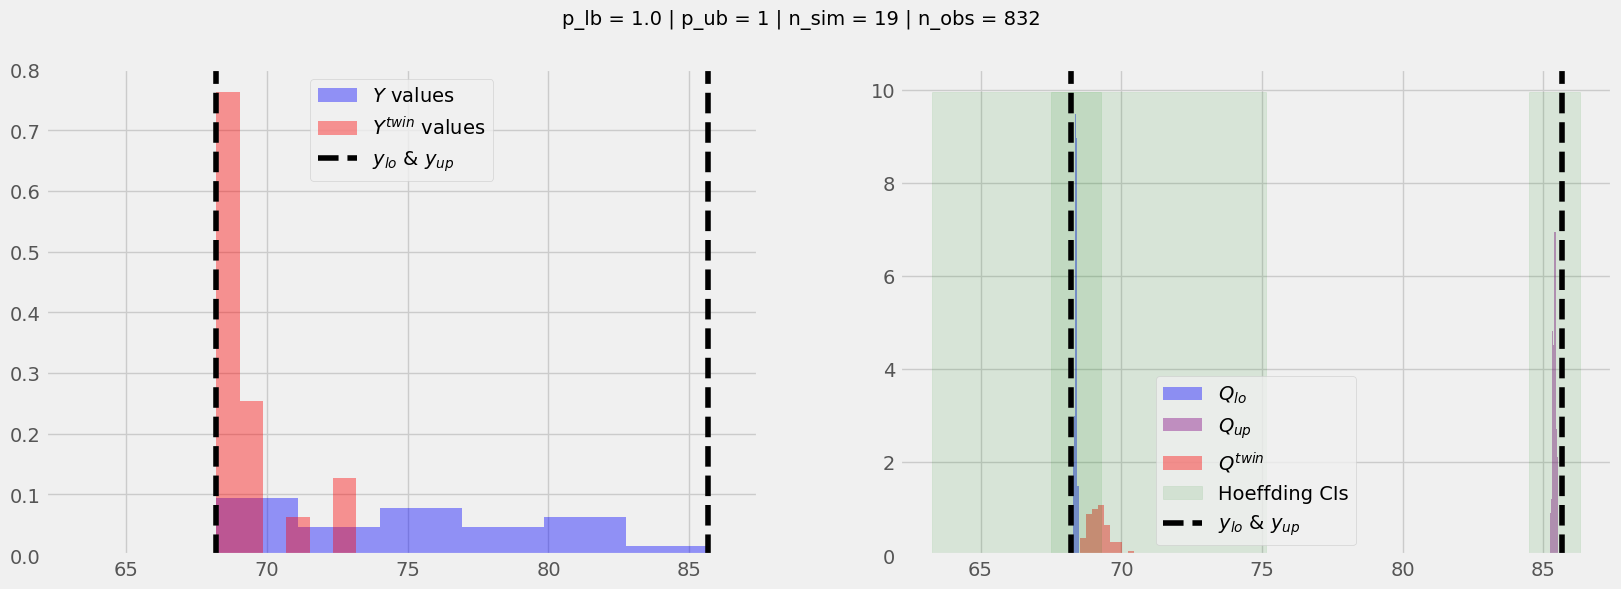

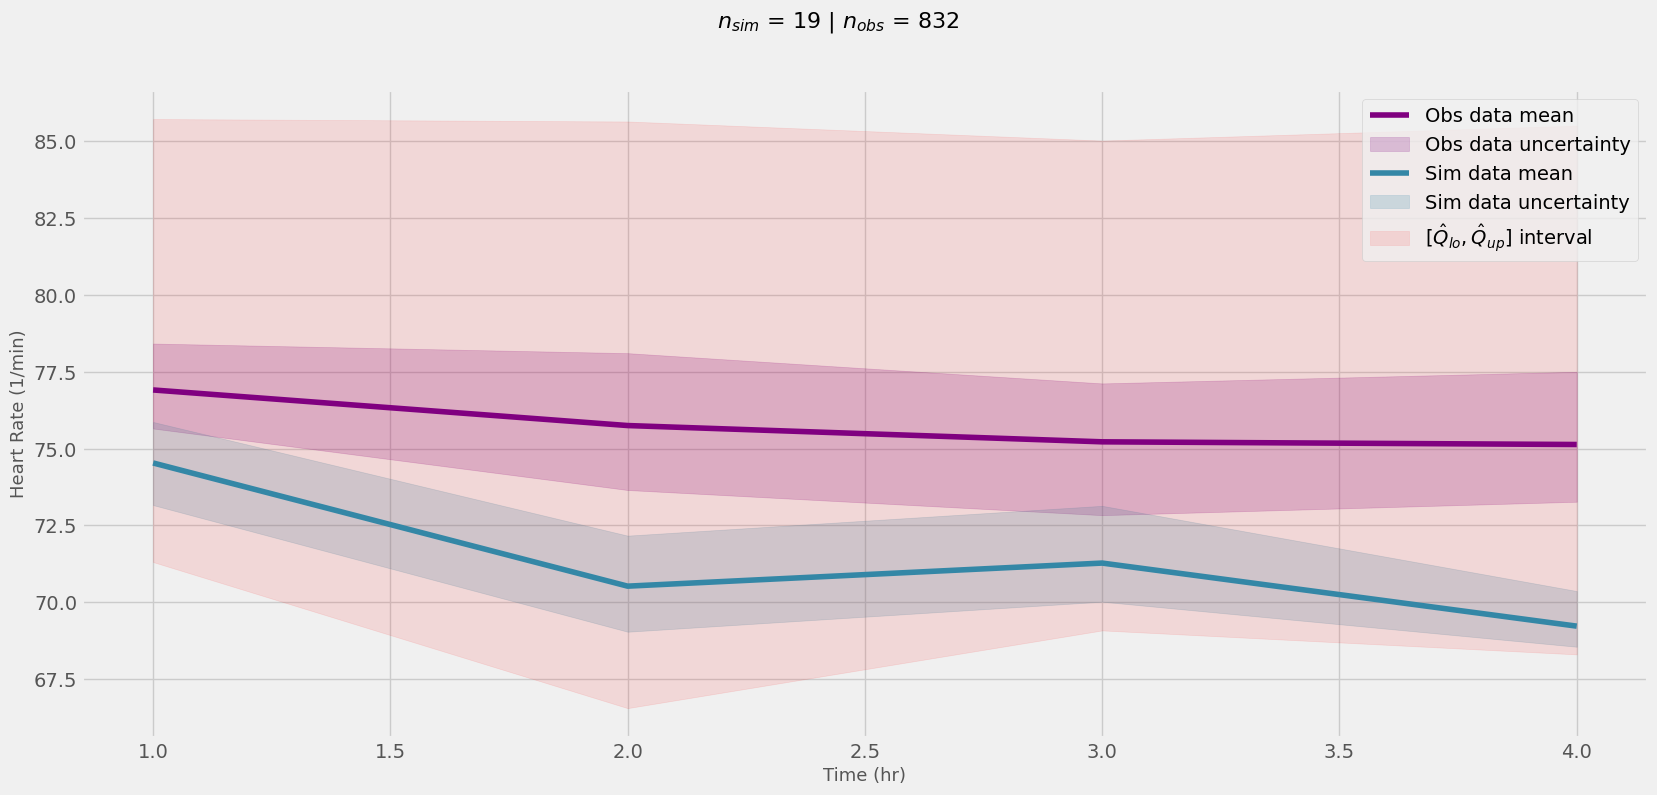

In [133]:
p_values_complete_trajecs = p_values[(p_values['t']==4)]

for index, row in tqdm(p_values_complete_trajecs.iterrows()):
    if index == 229:
        continue
    generate_histograms_bootstrapping(index, row, hyp_test_dir)
    
    generate_longitudinal_plots(row, p_values, hyp_test_dir)
    break

<AxesSubplot:>

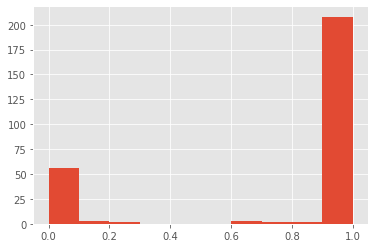

In [201]:
hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/rerun/boot_rev_perc/"
col="Calcium"

p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv", converters={'actions': eval, 'x_t': eval})
p_values = p_values.loc[p_values['t']>0]

p_values['p_lb'].hist()

In [793]:
p_vals_filtered = p_vals[(p_vals['col'] == 'HR') & (p_vals['t'] == 1)]

p_vals_filtered
len(p_vals_filtered)




76

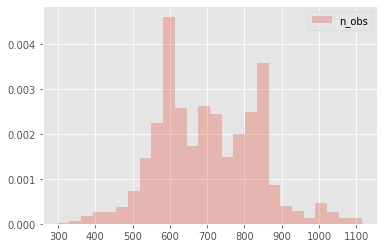

In [668]:
zx = plt.hist(p_vals['n_obs'], label='n_obs', density=True, alpha=0.3, bins='auto')
plt.legend()

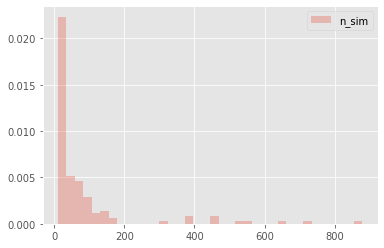

In [733]:
ax = plt.hist(p_vals_filtered['n_sim'], label='n_sim', density=True, alpha=0.3, bins='auto')
plt.legend()

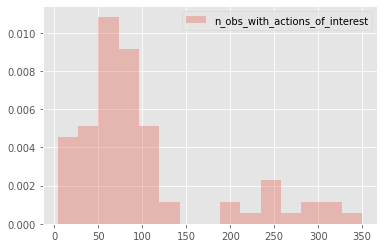

In [794]:
ax = plt.hist(p_vals_filtered['n_obs_with_actions_of_interest'], label='n_obs_with_actions_of_interest', density=True, alpha=0.3, bins='auto')
plt.legend()


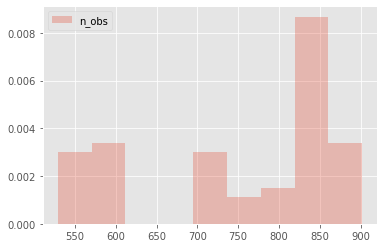

In [493]:
ax = plt.hist(p_vals_filtered['n_obs'], label='n_obs', density=True, alpha=0.3, bins='auto')
plt.legend()

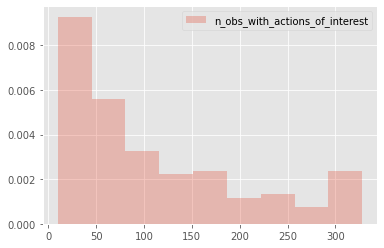

In [494]:
ax = plt.hist(p_vals_filtered['n_obs_with_actions_of_interest'], label='n_obs_with_actions_of_interest', density=True, alpha=0.3, bins='auto')
plt.legend()


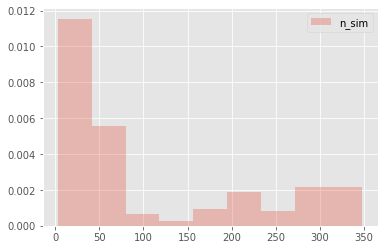

In [495]:
ax = plt.hist(p_vals_filtered['n_sim'], label='n_sim', density=True, alpha=0.3, bins='auto')
plt.legend()

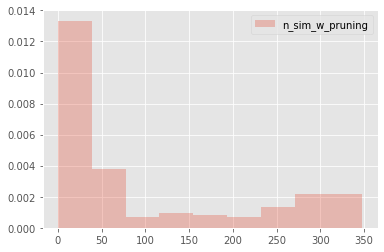

In [496]:
ax = plt.hist(p_vals_filtered['n_sim_w_pruning'], label='n_sim_w_pruning', density=True, alpha=0.3, bins='auto')
plt.legend()

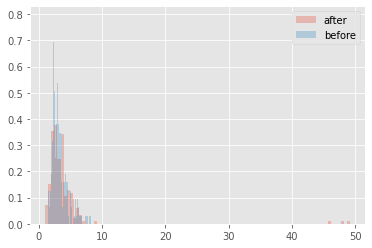

In [427]:
col_name = 'Temp_C'
p_vals['interval len'] = p_vals['Y_ub_mean'] - p_vals['Y_lb_mean']
p_vals1['interval len'] = p_vals1['Y_ub_mean'] - p_vals1['Y_lb_mean']


plt.hist(p_vals.loc[p_vals['col']==col_name, 'interval len'], label='after', density=True, alpha=0.3, bins=100)
plt.hist(p_vals1.loc[p_vals1['col']==col_name, 'interval len'], label='before', density=True, alpha=0.3, bins=60)
plt.legend()
# plt.xlim([0,10])

(array([ 25.,  61.,  80., 116.,  61.,  18.,   8.,   6.,   1.,   2.]),
 array([ 27.15789474,  37.90135014,  48.64480554,  59.38826094,
         70.13171635,  80.87517175,  91.61862715, 102.36208255,
        113.10553795, 123.84899336, 134.59244876]),
 <BarContainer object of 10 artists>)

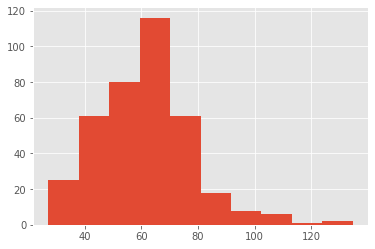

In [405]:
col_name = 'HR'
p_vals['interval len'] = p_vals['Y_ub_mean'] - p_vals['Y_lb_mean']

plt.hist(p_vals.loc[p_vals['col']=='HR', 'interval len'])

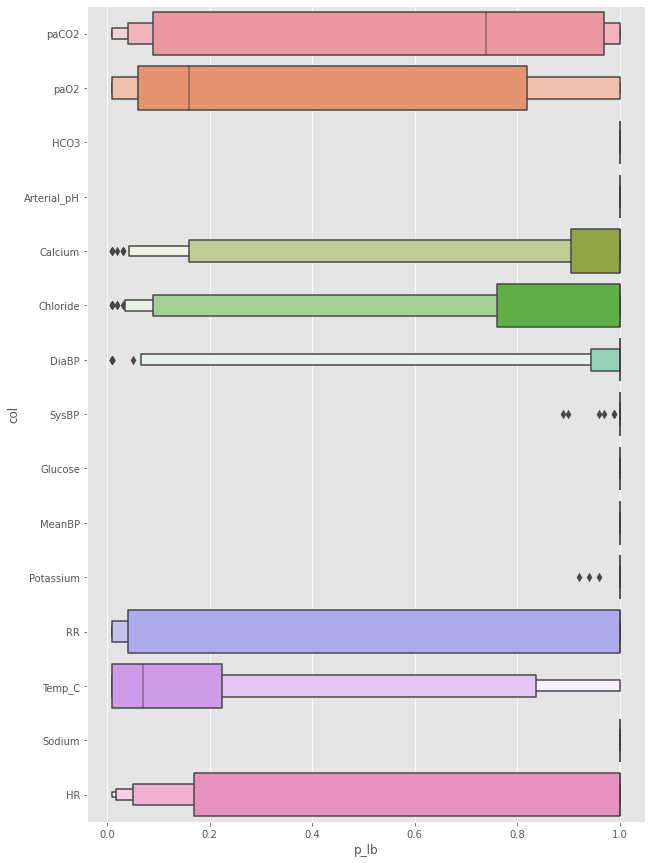

In [744]:
import seaborn as sns

# plt.figure(figsize=(15,8))
fig, axs = plt.subplots(1, figsize=(10,15))

ax = sns.boxenplot(x='p_lb', y='col', data=p_vals, ax=axs )

In [300]:
hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/rerun_w_qtwin/perc/"
hyp_test_dir_hoeff = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/rerun_w_qtwin/hoeff/"
check_df = pd.DataFrame()

data = {'columns':[], 'total_hypotheses':[], 'rejected_hypotheses': [], 'percentage_of_rejected_hyp': []}
for col in tqdm(column_names_dict):
    if os.path.exists(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv"):
        p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv", converters={'Sim_exp_y': eval, 'Exp_y': eval, 'Y_ub_mean': eval, 'Y_lb_mean': eval, 'actions': eval, 'x_t': eval})
        p_values = p_values.loc[p_values['t']>0]
        rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col}_hoeffFalse.csv", converters={'Sim_exp_y': eval, 'Exp_y': eval, 'Y_ub_mean': eval, 'Y_lb_mean': eval, 'actions': eval, 'x_t': eval})
#         rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col}_hoeffFalse.csv", converters= )
        rej_hyps = rej_hyps.loc[rej_hyps['t']>0]
        x0 = rej_hyps.loc[:,['gender', 'age', 'actions', 'x_t', 't']]
        x0['x_t'] = x0['x_t'].map(tuple)
        x0['actions'] = x0['actions'].map(tuple)
        x0 = x0.drop_duplicates()
        
        rej_hyps_hoeff = pd.read_csv(f"{hyp_test_dir_hoeff}/rej_hyps_{col}_hoeffTrue.csv", converters={'actions': eval, 'x_t': eval})
        x1 = rej_hyps_hoeff.loc[:,['gender', 'age', 'actions', 'x_t', 't']]
        x1['x_t'] = x1['x_t'].map(tuple)
        x1['actions'] = x1['actions'].map(tuple)
        x1 = x1.drop_duplicates()
        
        check_df = pd.concat([pd.merge(x0,x1, on=['gender', 'age', 'actions', 'x_t', 't'], how='outer', indicator='Exist'),check_df])
        data['columns'].append(col)
        data['total_hypotheses'].append(len(p_values))
        data['rejected_hypotheses'].append(len(rej_hyps))
        data['percentage_of_rejected_hyp'].append(len(rej_hyps)/len(p_values)*100)

results = pd.DataFrame(data)

In [181]:
results

,columns,total_hypotheses,rejected_hypotheses,percentage_of_rejected_hyp
0,paCO2,276,4,1.449275
1,paO2,276,12,4.347826
2,HCO3,276,0,0.000000
3,Arterial_pH,276,0,0.000000
4,Calcium,276,54,19.565217
5,Chloride,276,16,5.797101
6,DiaBP,276,0,0.000000
7,SysBP,276,0,0.000000
8,Glucose,276,0,0.000000
9,MeanBP,276,0,0.000000


In [152]:
# check_df = check_df.drop_duplicates()
# only rejected by Hoeffdings

(check_df['Exist'] == 'left_only').sum()/len(check_df)*100

# results['rejected_hypotheses'] - results_hoeff['rejected_hypotheses']
# len(check_df)

5.613305613305614

In [101]:
# sim_data.loc[sim_data['icustay_id']==3, "HR"]
col='HR'
rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col}_hoeffFalse.csv", converters={'actions': eval, 'x_t': eval})
x = rej_hyps.loc[:,['gender', 'age', 'actions', 'x_t', 't']]
x['x_t'] = x['x_t'].map(tuple)
x['actions'] = x['actions'].map(tuple)
pd.merge( x, x, on=['gender', 'age', 'actions', 'x_t', 't'], how='left', indicator='Exist')

,gender,age,actions,x_t,t,Exist
0,0.0,2.0,"(5, 5, 5, 5)","(3, 3, 3, 3)",2,both
1,1.0,4.0,"(3, 3, 3, 3)","(1, 1, 1, 1)",0,both
2,0.0,3.0,"(3, 3, 3, 3)","(0, 0, 0, 0)",0,both
3,1.0,2.0,"(3, 3, 3, 3)","(4, 4, 4, 4)",0,both
4,0.0,4.0,"(4, 4, 4, 4)","(1, 1, 1, 1)",0,both
...,...,...,...,...,...,...
103,0.0,1.0,"(3, 3, 3, 3)","(1, 1, 3, 3)",0,both
104,0.0,3.0,"(3, 3, 3, 3)","(1, 3, 1, 1)",0,both
105,1.0,3.0,"(3, 3, 3, 3)","(1, 3, 1, 1)",0,both
106,0.0,4.0,"(3, 3, 3, 3)","(1, 1, 1, 3)",0,both


In [14]:
observational_data.loc[(observational_data['A']==4),'input_1hourly'].max()


19.9997

In [75]:
eps = np.random.randn(5)*2

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_icustayid(outcome, icustayids, axis):
    obs_data_patient = observational_data.loc[observational_data['icustay_id'].isin(icustayids), ['bloc', outcome]]
    sim_data_patient = sim_data.loc[sim_data['icustay_id'].isin(icustayids), ['bloc', outcome]]
    if len(obs_data_patient) == 0 or len(sim_data_patient) == 0:
        return
    x = range(5)
    obs_std = obs_data_patient.groupby(by='bloc').std()[outcome]
    obs_mean = obs_data_patient.groupby(by='bloc').mean()[outcome]
    sim_std = sim_data_patient.groupby(by='bloc').std()[outcome]
    sim_mean = sim_data_patient.groupby(by='bloc').mean()[outcome] + eps
    mse = ((obs_mean-sim_mean)**2).mean()
    axis.plot(x, obs_mean, color = sns.color_palette("mako", 10)[2], label="Obs data mean")
    axis.fill_between(x, obs_mean - obs_std, obs_mean + obs_std, label="Obs data uncertainty", color=sns.color_palette("mako", 10)[6], alpha = 0.4)
    axis.plot(x, sim_mean, color = sns.color_palette("mako", 10)[5], label="Sim data mean")
    axis.fill_between(x, sim_mean - sim_std, sim_mean + sim_std, label="Sim data uncertainty", color=sns.color_palette("mako", 10)[9], alpha = 0.4)
    plt.style.use('fivethirtyeight')
    return mse
    

In [253]:
# action_trajec = [3,5,3,3]
# # initial_x = [2,2,2,2]
# gender = 1
# age = 3
# # icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec) & (trajec_actions['gender']==gender) & (trajec_actions['age']==age), 'icustay_id']
# x = trajec_actions.loc[trajec_actions['actions'].apply(lambda x: x == action_trajec), 'x_t']
# x

# icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec), 'icustay_id']

action_trajec = [3,3,3,3]
initial_x = [1,1,1,1]
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec), 'icustay_id']

icustayids_filtered

25         238.0
30         302.0
50         456.0
53         481.0
123       1083.0
          ...   
11606    99382.0
11616    99502.0
11638    99656.0
11641    99679.0
11647    99756.0
Name: icustay_id, Length: 576, dtype: float64

96
78


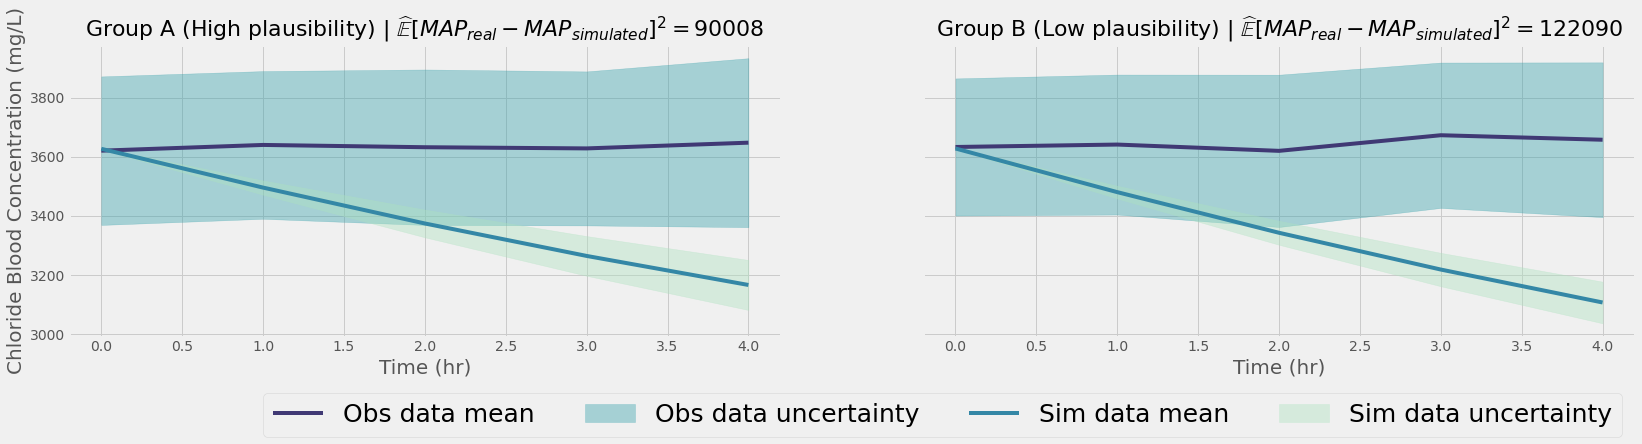

In [289]:
fig, axs = plt.subplots(1, 2, figsize=(25,5), sharey=True)

action_trajec = [3,3,3,3]
initial_x = [1, 1, 1, 1]
gender = 0
age = 4
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec) & (trajec_actions['gender']==gender) & (trajec_actions['age']==age), 'icustay_id']
print(len(icustayids_filtered))
mse2 = plot_icustayid("Temp_C", icustayids_filtered, axs[0])
# axs[0].axvspan(1, 2, alpha=0.35, color='gray', label="IV fluid (150 mL) administered")
axs[0].set_xlabel("Time (hr)", fontsize=20)
axs[0].set_ylabel("Chloride Blood Concentration (mg/L)", fontsize=20)
axs[0].set_title(f"Group A (High plausibility) | $\widehat{{\mathbb{{E}}}}[MAP_{{real}} - MAP_{{simulated}}]^2={int(mse2)}$", fontsize=22)


action_trajec = [3,3,3,3]
initial_x = [1, 1, 1, 1]
gender = 1
age = 3
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec) & (trajec_actions['gender']==gender) & (trajec_actions['age']==age), 'icustay_id']
print(len(icustayids_filtered))
x = range(5)
mse1 = plot_icustayid("Temp_C", icustayids_filtered, axs[1])
# axs[1].axvspan(3, 4, alpha=0.15, color='gray', label="IV fluid (20 mL) administered")
axs[1].set_xlabel("Time (hr)", fontsize=20)
# axs[1].set_ylabel("Mean Arterial Pressure (MAP) (mmHg)")
axs[1].set_title(f"Group B (Low plausibility) | $\widehat{{\mathbb{{E}}}}[MAP_{{real}} - MAP_{{simulated}}]^2={int(mse1)}$", fontsize=22)
# axs[1].set_ylim([55,110])


# plt.ylim([2000,4000])
plt.legend(ncol=5, bbox_to_anchor=(1,-0.15), fontsize=25)


26
11


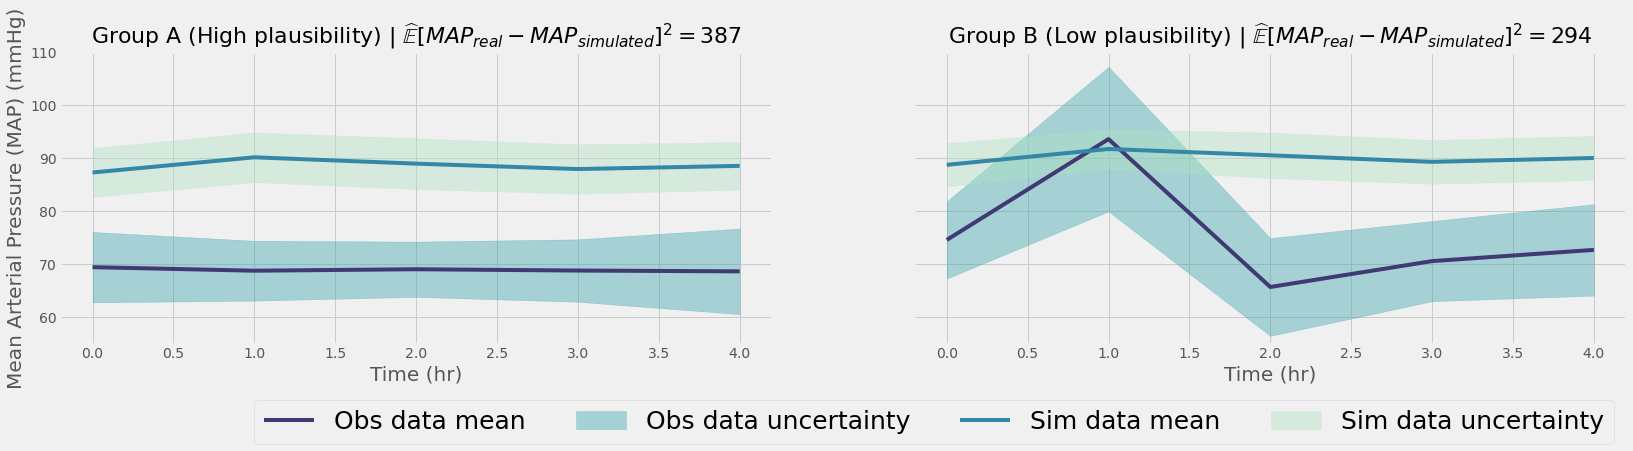

In [284]:
fig, axs = plt.subplots(1, 2, figsize=(25,5), sharey=True)

action_trajec = [5, 5, 5, 5]
initial_x = [1,1,1,1]
gender = 0
age = 4
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec) & (trajec_actions['gender']==gender) & (trajec_actions['age']==age), 'icustay_id']
print(len(icustayids_filtered))
mse2 = plot_icustayid("MeanBP", icustayids_filtered, axs[0])
# axs[0].axvspan(1, 2, alpha=0.35, color='gray', label="IV fluid (150 mL) administered")
axs[0].set_xlabel("Time (hr)", fontsize=20)
axs[0].set_ylabel("Mean Arterial Pressure (MAP) (mmHg)", fontsize=20)
axs[0].set_title(f"Group A (High plausibility) | $\widehat{{\mathbb{{E}}}}[MAP_{{real}} - MAP_{{simulated}}]^2={int(mse2)}$", fontsize=22)


action_trajec = [3,3,3,3]
initial_x = [1,3,1,1]
gender = 1
age = 3
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec) & (trajec_actions['gender']==gender) & (trajec_actions['age']==age), 'icustay_id']
print(len(icustayids_filtered))
x = range(5)
mse1 = plot_icustayid("MeanBP", icustayids_filtered, axs[1])
# axs[1].axvspan(3, 4, alpha=0.15, color='gray', label="IV fluid (20 mL) administered")
axs[1].set_xlabel("Time (hr)", fontsize=20)
# axs[1].set_ylabel("Mean Arterial Pressure (MAP) (mmHg)")
axs[1].set_title(f"Group B (Low plausibility) | $\widehat{{\mathbb{{E}}}}[MAP_{{real}} - MAP_{{simulated}}]^2={int(mse1)}$", fontsize=22)
axs[1].set_ylim([55,110])


# plt.ylim([2000,4000])
plt.legend(ncol=5, bbox_to_anchor=(1,-0.15), fontsize=25)


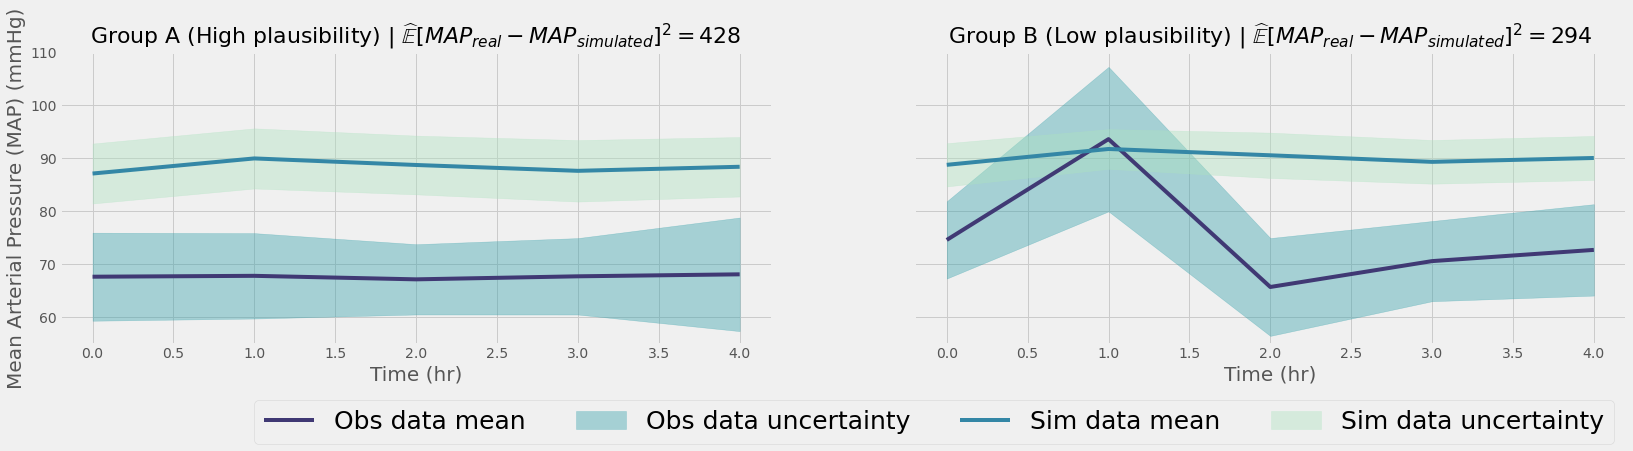

In [282]:
fig, axs = plt.subplots(1, 2, figsize=(25,5), sharey=True)

action_trajec = [3,3,3,3]
initial_x = [1,1,1,1]
gender = 1
age = 4
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec) & (trajec_actions['gender']==gender) & (trajec_actions['age']==age), 'icustay_id']
mse2 = plot_icustayid("MeanBP", icustayids_filtered, axs[0])
# axs[0].axvspan(1, 2, alpha=0.35, color='gray', label="IV fluid (150 mL) administered")
axs[0].set_xlabel("Time (hr)", fontsize=20)
axs[0].set_ylabel("Mean Arterial Pressure (MAP) (mmHg)", fontsize=20)
axs[0].set_title(f"Group A (High plausibility) | $\widehat{{\mathbb{{E}}}}[MAP_{{real}} - MAP_{{simulated}}]^2={int(mse2)}$", fontsize=22)


action_trajec = [3,3,3,3]
initial_x = [1,3,1,1]
gender = 1
age = 3
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec) & (trajec_actions['gender']==gender) & (trajec_actions['age']==age), 'icustay_id']
x = range(5)
mse1 = plot_icustayid("MeanBP", icustayids_filtered, axs[1])
# axs[1].axvspan(3, 4, alpha=0.15, color='gray', label="IV fluid (20 mL) administered")
axs[1].set_xlabel("Time (hr)", fontsize=20)
# axs[1].set_ylabel("Mean Arterial Pressure (MAP) (mmHg)")
axs[1].set_title(f"Group B (Low plausibility) | $\widehat{{\mathbb{{E}}}}[MAP_{{real}} - MAP_{{simulated}}]^2={int(mse1)}$", fontsize=22)
axs[1].set_ylim([55,110])


# plt.ylim([2000,4000])
plt.legend(ncol=5, bbox_to_anchor=(1,-0.15), fontsize=25)


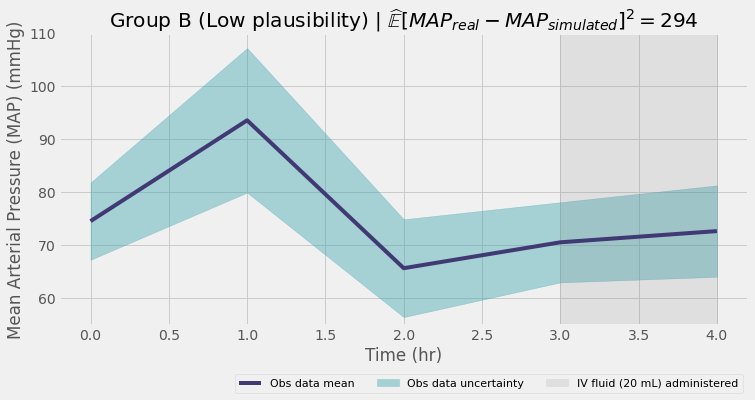

In [144]:
action_trajec = [3,3,3,3]
initial_x = [1,3,1,1]
gender = 1
age = 3
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec) & (trajec_actions['gender']==gender) & (trajec_actions['age']==age), 'icustay_id']
x = range(5)
fig, axs = plt.subplots(1, 1, figsize=(11,5))
mse = plot_icustayid("MeanBP", icustayids_filtered, axs)
axs.axvspan(3, 4, alpha=0.15, color='gray', label="IV fluid (20 mL) administered")
plt.xlabel("Time (hr)")
plt.ylabel("Mean Arterial Pressure (MAP) (mmHg)")
plt.title(f"Group B (Low plausibility) | $\widehat{{\mathbb{{E}}}}[MAP_{{real}} - MAP_{{simulated}}]^2={int(mse)}$")
plt.ylim([55,110])
# plt.ylim([2000,4000])
plt.legend(ncol=5, bbox_to_anchor=(1,-0.15), fontsize=25, prop={'size': 11})


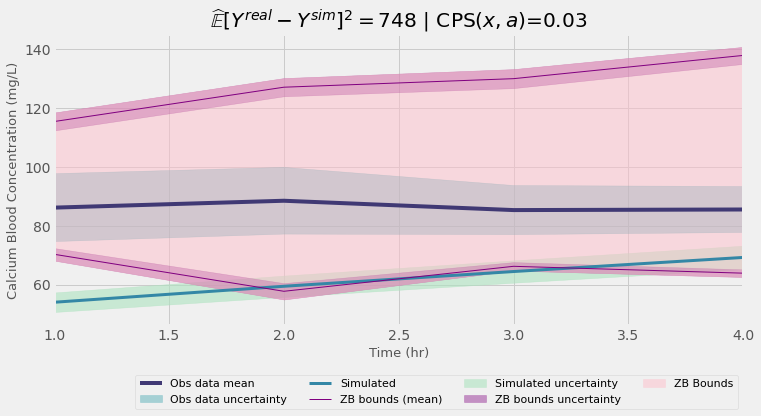

In [143]:
action_trajec = [3,3,3,3]
initial_x = [1,1,1,1]
gender = 1
age = 4
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec) & (trajec_actions['gender']==gender) & (trajec_actions['age']==age), 'icustay_id']
x = range(5)
fig, axs = plt.subplots(1, 1, figsize=(11,5))
mse = plot_icustayid("Calcium", icustayids_filtered, axs)
# axs.axvspan(3, 4, alpha=0.15, color='gray', label="IV fluid (20 mL) administered")
plot_bounds_bootstrap("Calcium", gender, age, action_trajec, initial_x, axis=axs)
plt.xlabel("Time (hr)")
plt.ylabel("Calcium Blood Concentration (mg/L)")
plt.title(f"$\widehat{{\mathbb{{E}}}}[Y^{{real}} - Y^{{sim}}]^2={int(mse)}$ | CPS$(x, a)$=0.03")
# plt.ylim([55,110])
# plt.ylim([2000,4000])
plt.xlim([1,4])


plt.legend(ncol=4, bbox_to_anchor=(1,-0.15), fontsize=16, prop={'size': 11})


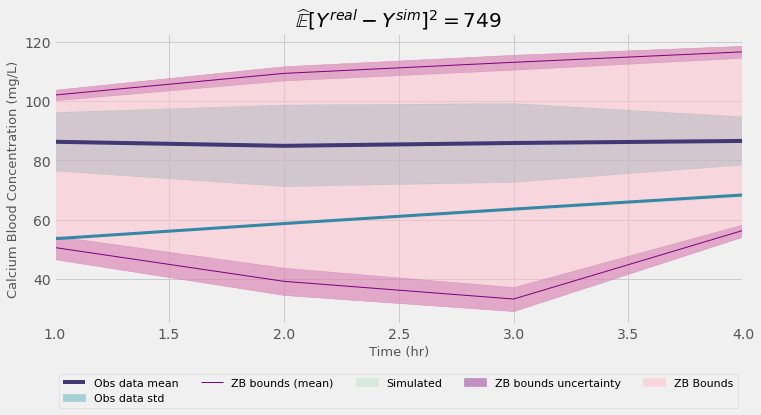

In [131]:
action_trajec = [3,3,3,3]
initial_x = [3,3,3,3]
gender = 0
age = 2
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec) & (trajec_actions['gender']==gender) & (trajec_actions['age']==age), 'icustay_id']
x = range(5)
fig, axs = plt.subplots(1, 1, figsize=(11,5))
mse = plot_icustayid("Calcium", icustayids_filtered, axs)
# axs.axvspan(3, 4, alpha=0.15, color='gray', label="IV fluid (20 mL) administered")
plot_bounds_bootstrap("Calcium", gender, age, action_trajec, initial_x, axis=axs)
plt.xlabel("Time (hr)")
plt.ylabel("Calcium Blood Concentration (mg/L)")
plt.title(f"$\widehat{{\mathbb{{E}}}}[Y^{{real}} - Y^{{sim}}]^2={int(mse)}$")
# plt.ylim([55,110])
# plt.ylim([2000,4000])
plt.xlim([1,4])


plt.legend(ncol=5, bbox_to_anchor=(1,-0.15), fontsize=16, prop={'size': 11})


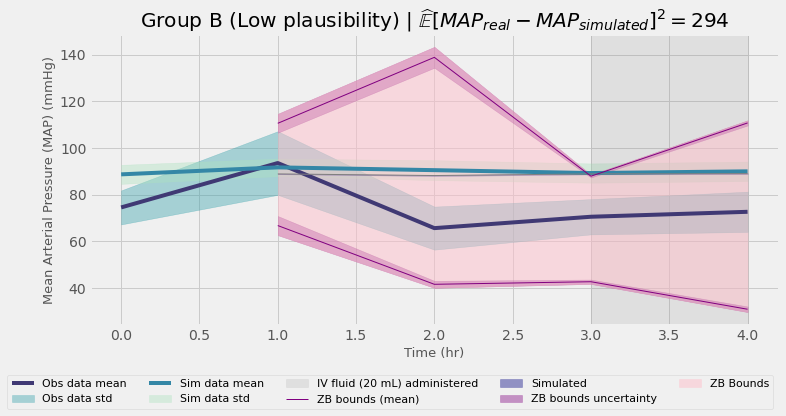

In [103]:
action_trajec = [3,3,3,3]
initial_x = [1,3,1,1]
gender = 1
age = 3
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec) & (trajec_actions['gender']==gender) & (trajec_actions['age']==age), 'icustay_id']
x = range(5)
fig, axs = plt.subplots(1, 1, figsize=(11,5))
mse = plot_icustayid("MeanBP", icustayids_filtered, axs)
axs.axvspan(3, 4, alpha=0.15, color='gray', label="IV fluid (20 mL) administered")
plot_bounds_bootstrap("MeanBP", gender, age, action_trajec, initial_x, axis=axs)
plt.xlabel("Time (hr)")
plt.ylabel("Mean Arterial Pressure (MAP) (mmHg)")
plt.title(f"Group B (Low plausibility) | $\widehat{{\mathbb{{E}}}}[MAP_{{real}} - MAP_{{simulated}}]^2={int(mse)}$")
# plt.ylim([55,110])
# plt.ylim([2000,4000])
# plt.xlim([1,4])


plt.legend(ncol=5, bbox_to_anchor=(1,-0.15), fontsize=16, prop={'size': 11})


In [104]:
action_trajec = [3,2,3,3]
initial_x = [1,1,1,1]
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec), 'icustay_id']
x = range(5)
fig, axs = plt.subplots(1, 1, figsize=(11,5))
mse = plot_icustayid("MeanBP", icustayids_filtered, axs)
axs.axvspan(1, 2, alpha=0.3, color='gray', label="IV fluid (150 mL) administered")
plot_bounds_bootstrap("MeanBP", gender, age, action_trajec, initial_x, axis=axs)
plt.xlabel("Time (hr)")
plt.ylabel("Mean Arterial Pressure (MAP) (mmHg)")
plt.title(f"Group A (High plausibility) | $\widehat{{\mathbb{{E}}}}[MAP_{{real}} - MAP_{{simulated}}]^2={int(mse)}$")
# plt.ylim([55,110])
plt.xlim([1, 4])
plt.legend(ncol=5, bbox_to_anchor=(1,-0.15), fontsize=16, prop={'size': 11})


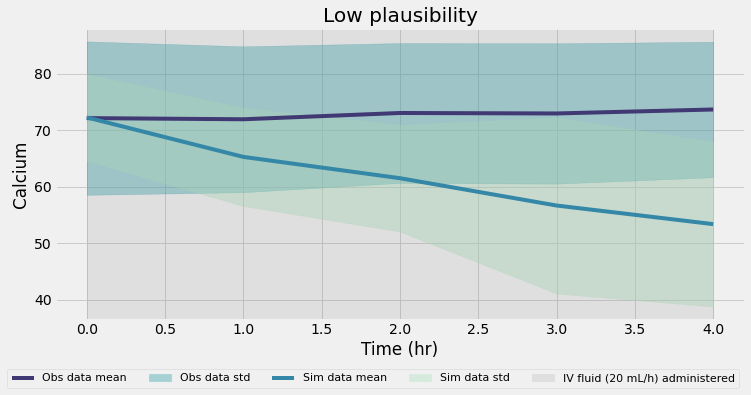

In [17]:
action_trajec = [2,2,2,2]
initial_x = [3,3,3,3]
gender = 0
age = 1
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec) & (trajec_actions['gender']==gender) & (trajec_actions['age']==age), 'icustay_id']
x = range(5)
fig, axs = plt.subplots(1, 1, figsize=(11,5))
plot_icustayid("DiaBP", icustayids_filtered, axs)
axs.axvspan(0, 4, alpha=0.15, color='gray', label="IV fluid (20 mL/h) administered")
plt.xlabel("Time (hr)")
plt.ylabel("Calcium")
plt.title("Low plausibility")
# plt.ylim([55,110])
# plt.ylim([2000,4000])
plt.legend(ncol=5, bbox_to_anchor=(1,-0.15), fontsize=16, prop={'size': 11})


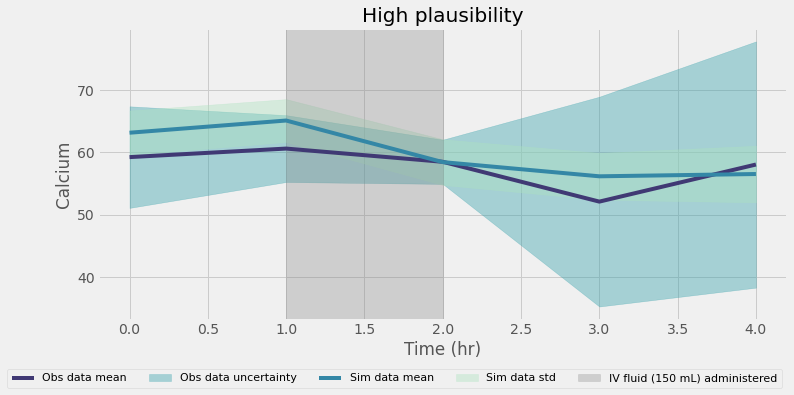

In [179]:
action_trajec = [3,2,3,3]
initial_x = [1,1,1,1]
gender = 0
age = 3
icustayids_filtered = trajec_actions.loc[trajec_actions['x_t'].apply(lambda x: x == initial_x) & trajec_actions['actions'].apply(lambda x: x == action_trajec) & (trajec_actions['gender']==gender) & (trajec_actions['age']==age), 'icustay_id']
x = range(5)
fig, axs = plt.subplots(1, 1, figsize=(11,5))
plot_icustayid("DiaBP", icustayids_filtered, axs)
axs.axvspan(1, 2, alpha=0.3, color='gray', label="IV fluid (150 mL) administered")
plt.xlabel("Time (hr)")
plt.ylabel("Calcium")
plt.title("High plausibility")
# plt.ylim([55,110])
# plt.ylim([2000,4000])
plt.legend(ncol=5, bbox_to_anchor=(1,-0.15), fontsize=16, prop={'size': 11})


In [240]:
rej_hyps.head()
# len(p_values)

,Unnamed: 0,Exp_y,M_0.05_quantiles,M_0.95_quantiles,Sim_exp_y,actions,age,gender,p,x_t,n_real,n_sim
0,2,87.489028,"[21.13847285170211, 43.06951515987587, 55.3924...","[33.42177874771837, 49.29119803315931, 59.2368...",68.498471,"[3, 3, 3, 3]",1.0,1.0,0.0,"[1, 1, 1, 1]",36.0,31.0
1,3,85.550000,"[10.623065971038855, 36.74854296702582, 53.822...","[22.57536734540507, 43.62058533696419, 57.2113...",69.184027,"[3, 3, 3, 3]",4.0,1.0,0.0,"[1, 1, 1, 1]",75.0,51.0
2,5,84.733381,"[4.859393848809061, 37.63091844023758, 50.7609...","[18.527419768624405, 44.02427261431538, 55.288...",68.303257,"[3, 3, 3, 3]",3.0,0.0,0.0,"[1, 1, 1, 1]",105.0,79.0
3,6,84.255172,"[13.231624516476124, 41.00192415684895, 55.061...","[26.868087320017295, 47.643575923628305, 59.36...",68.021651,"[3, 3, 3, 3]",4.0,0.0,0.0,"[3, 3, 3, 3]",29.0,90.0
4,7,84.878696,"[49.787038712422664, 55.30131697153, 60.488407...","[51.53055369772746, 57.95603969180054, 63.6628...",68.037537,"[5, 5, 5, 5]",3.0,0.0,0.0,"[1, 1, 1, 1]",23.0,16.0


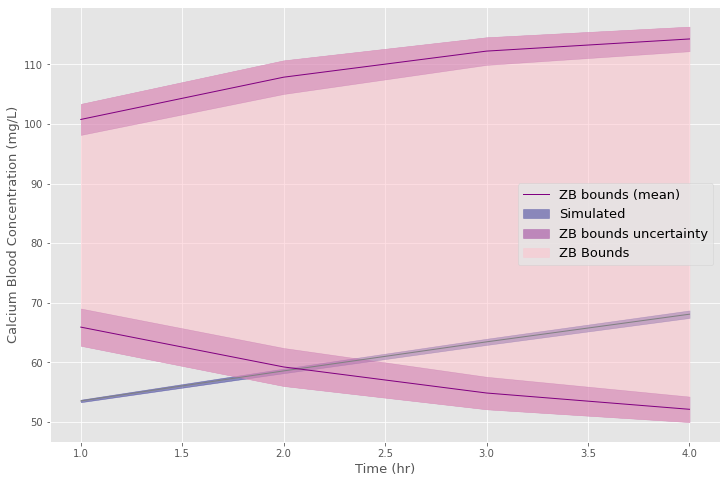

In [85]:
hyp_test_dir
plot_bounds_bootstrap(col_name, 0, 4, [3, 3, 3, 3], [3,3,3,3])

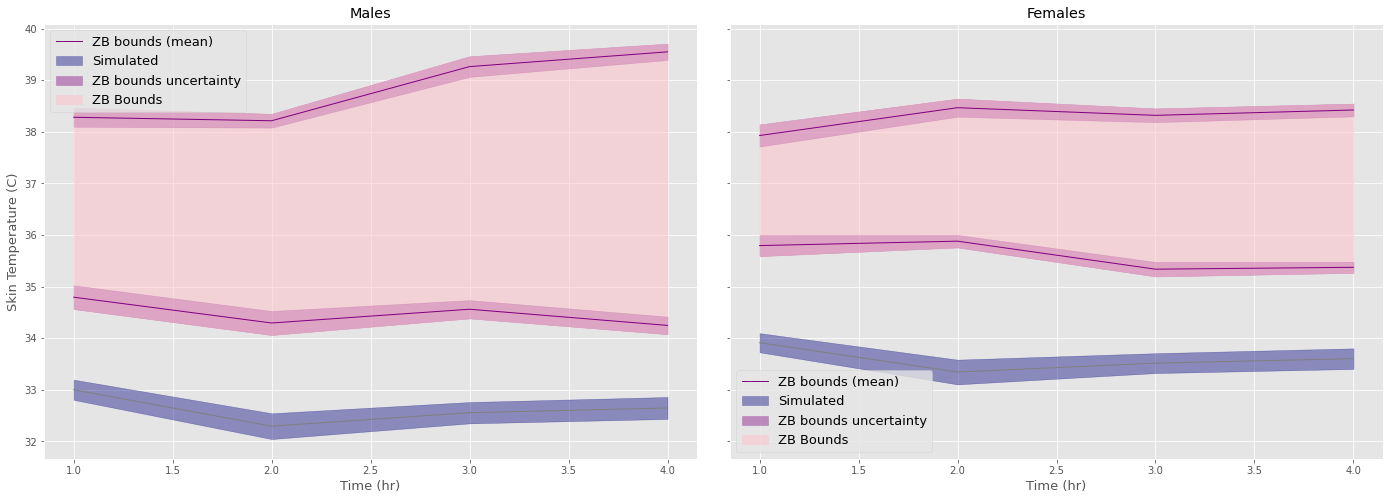

In [87]:
col_name="Temp_C"
fig, axs = plt.subplots(1, 2, figsize=(24,8), sharey=True)
plot_bounds_bootstrap(col_name, 0, 2, [3,3,3,3], [3, 3, 3, 3], axis=axs[0])
axs[0].set_title("Males")
plot_bounds_bootstrap(col_name, 1, 2, [3,3,3,3], [3, 3, 3, 3], axis=axs[1])
axs[1].set_ylabel("")
axs[1].set_title("Females")

plt.subplots_adjust(wspace=0.05)

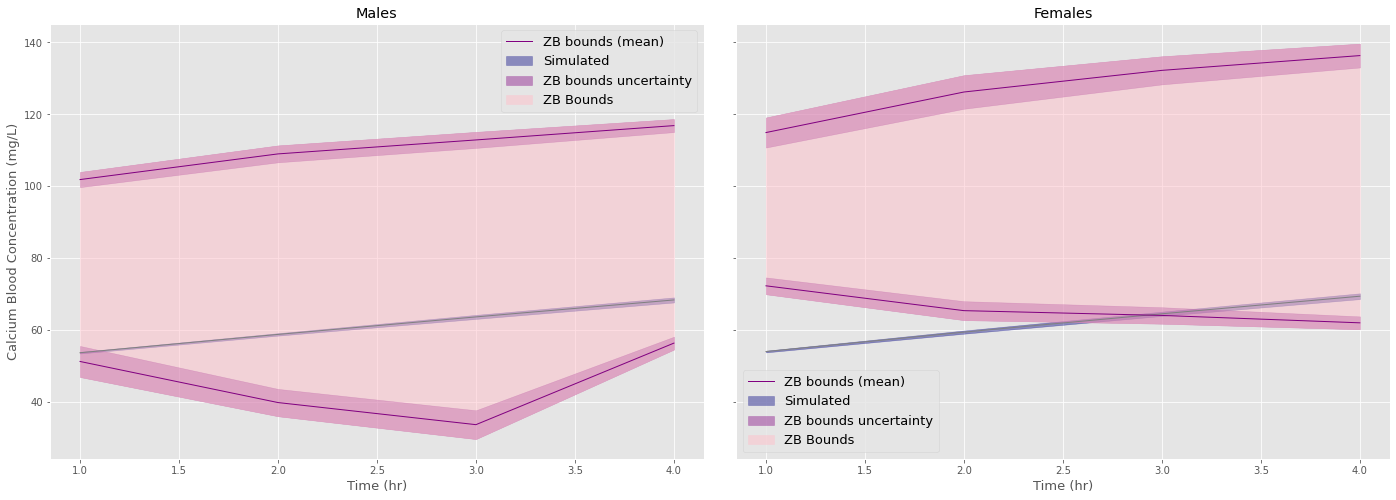

In [88]:
col_name="Calcium"
fig, axs = plt.subplots(1, 2, figsize=(24,8), sharey=True)
plot_bounds_bootstrap(col_name, 0, 2, [3,3,3,3], [3, 3, 3, 3], axis=axs[0])
axs[0].set_title("Males")
plot_bounds_bootstrap(col_name, 1, 2, [3,3,3,3], [3, 3, 3, 3], axis=axs[1])
axs[1].set_ylabel("")
axs[1].set_title("Females")

plt.subplots_adjust(wspace=0.05)

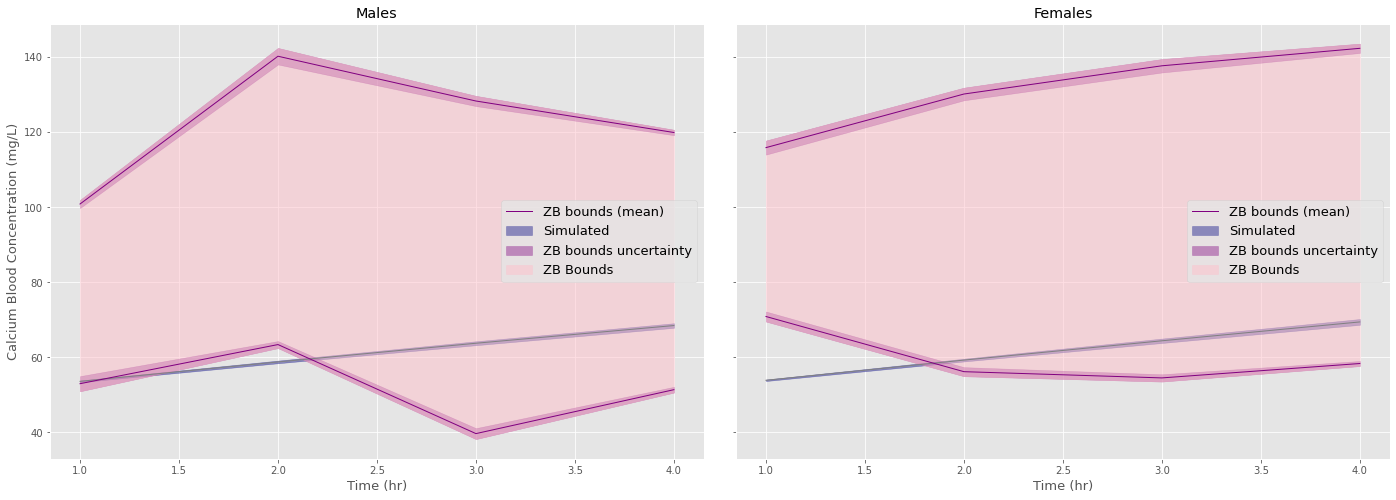

In [35]:
col_name="Calcium"
fig, axs = plt.subplots(1, 2, figsize=(24,8), sharey=True)
plot_bounds_bootstrap(col_name, 0, 2, [3,3,3,3], [3, 3, 3, 3], axis=axs[0])
axs[0].set_title("Males")
plot_bounds_bootstrap(col_name, 1, 2, [3,3,3,3], [3, 3, 3, 3], axis=axs[1])
axs[1].set_ylabel("")
axs[1].set_title("Females")

plt.subplots_adjust(wspace=0.05)

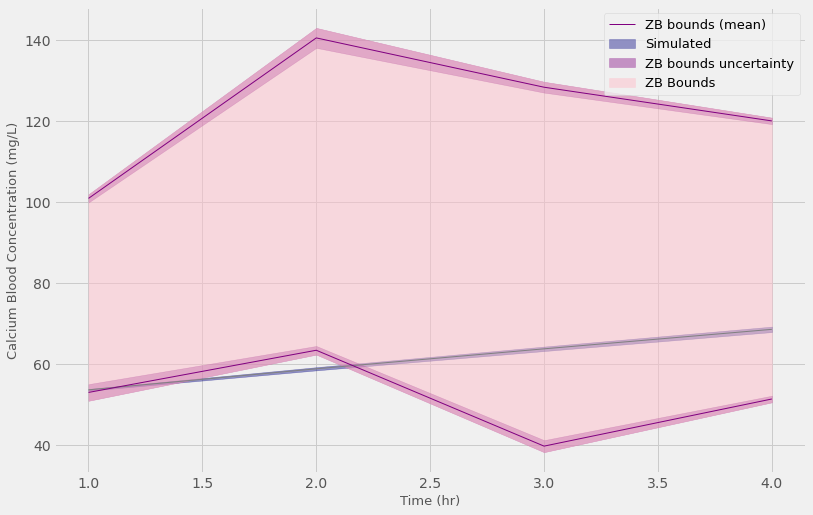

In [50]:
plot_bounds_bootstrap(col_name, 0, 2, [3,3,3,3], [3, 3, 3, 3])

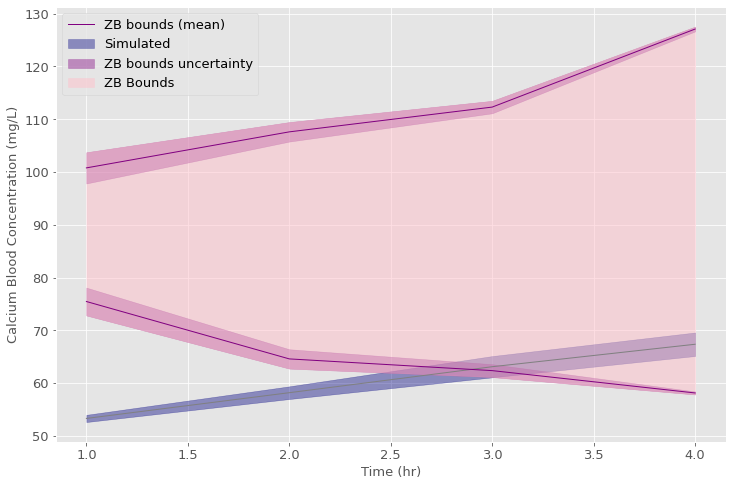

In [29]:
plot_bounds_bootstrap(col_name, 0, 4, [3.0, 3.0, 3.0, 4.0], [3,3,3,3])

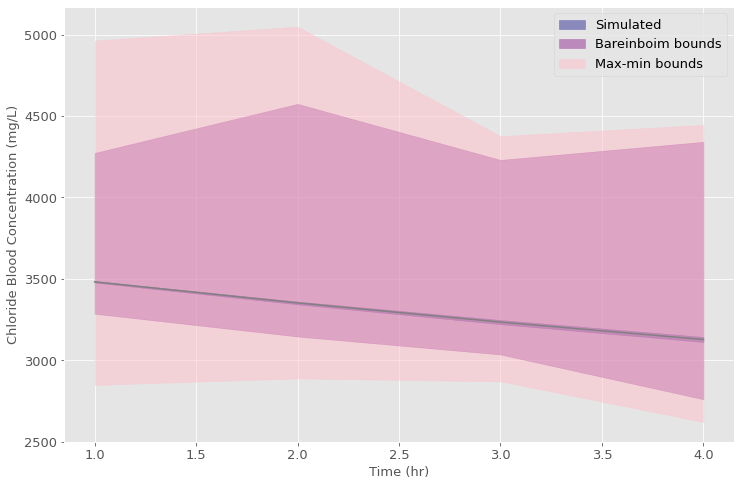

In [74]:
plot_bounds_bootstrap(col_name, 0, 2, [3, 3, 3, 3], [1, 1, 1, 1])

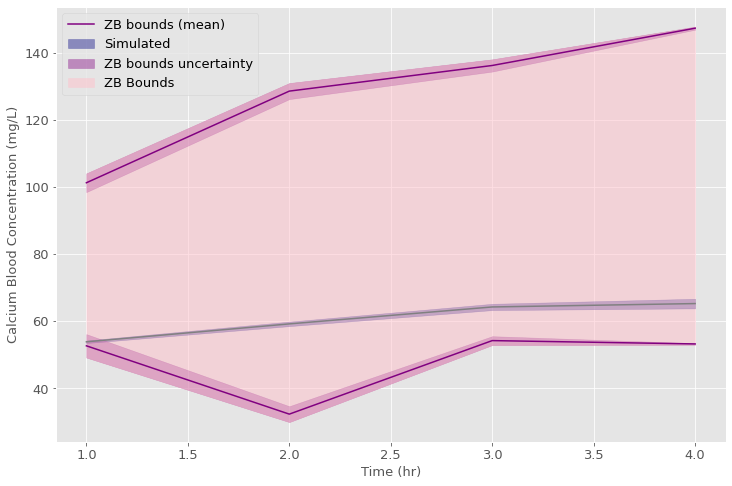

In [55]:
plot_bounds_bootstrap(col_name, 1, 4, [3.0, 3.0, 3.0, 2.0], [3, 3, 3, 3])

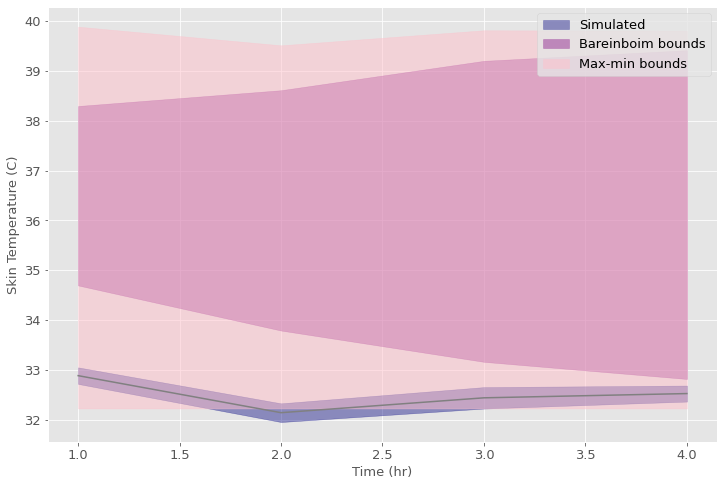

In [97]:
plot_bounds_bootstrap(col_name, 0, 2, [3.0, 3.0, 3.0, 3.0], [1, 1, 1, 1])

## Visualise p-values (# bins = 7) 

100%|██████████| 15/15 [00:00<00:00, 111.28it/s]


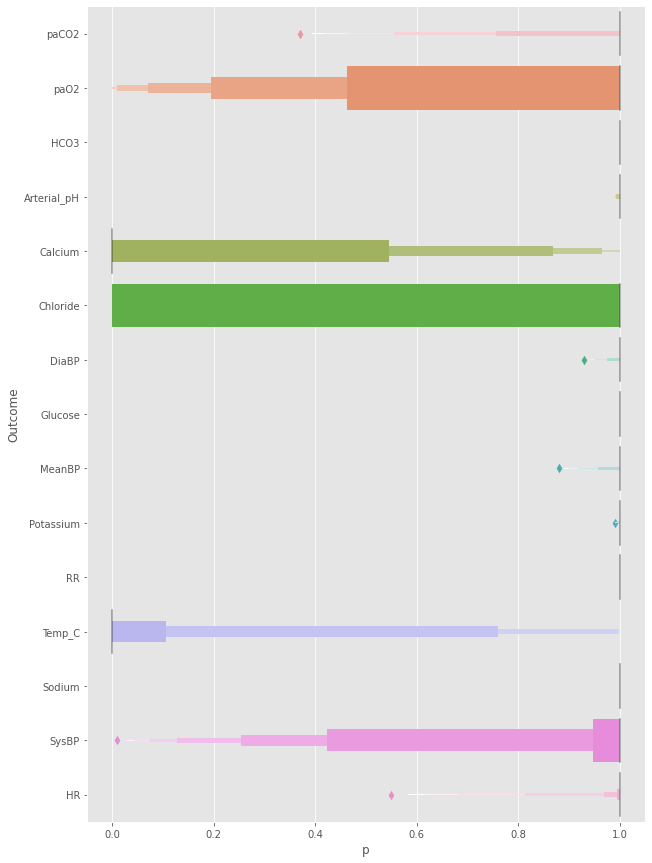

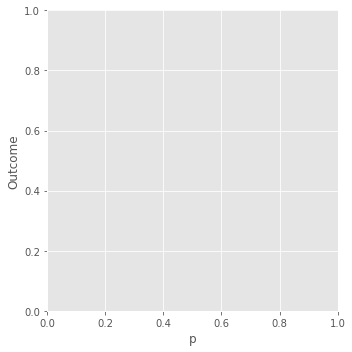

In [27]:
import seaborn as sns
hyp_test_dir = "/data/localhost/taufiq/bootstrap_kmeans/pulse_7_bins/"
x_columns = ['paCO2', 'paO2', 'HCO3', 'Arterial_pH', 'Calcium', 'Chloride', 'DiaBP', 'Glucose', 'MeanBP', 'Potassium', 'RR', 'Temp_C', 'Sodium', 'SysBP', 'HR']
combined_p_values = pd.DataFrame()
for col_name in tqdm(x_columns):
    p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col_name}.csv", converters={'actions': eval, col_name: eval})
    p_values.rename(columns={col_name: 'col_v'}, inplace=True)
    p_values['Outcome'] = col_name
    combined_p_values = combined_p_values.append(p_values, ignore_index=True)

fig, axs = plt.subplots(1, figsize=(10,15))    
sns.catplot(x='p',y='Outcome', data=combined_p_values, ax=axs, kind="boxen")

## Visualise p-values (# bins = 5) 

In [30]:
# p_values.head()
combined_cls_scores = pd.DataFrame(columns=['actions', 'casadsac'])
combined_cls_scores.at[0, 'actions'] = 1
combined_cls_scores.head()

,actions,casadsac
0,1,NaN


In [60]:
hyp_test_dir = "/data/localhost/taufiq/hyp_test_dir_MIMIC_combined/"
x_columns = ['paCO2', 'paO2', 'Arterial_pH', 'Calcium', 'Chloride', 'DiaBP', 'Glucose', 'MeanBP', 'Potassium', 'RR', 'Temp_C', 'Sodium', 'SysBP', 'HR']

combined_cls_scores = pd.DataFrame(columns=['Outcome','CPS $\leq 0.05$', 'CPS $\in [0.05,0.95]$', 'CPS $> 0.95$'])
index = 0
for col_name in x_columns:
    p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col_name}.csv", converters={'actions': eval, col_name: eval})
    combined_cls_scores.at[index, 'Outcome'] = column_names_dict[col_name]
    combined_cls_scores.at[index, 'CPS $\leq 0.05$'] = str((p_values['p']<=0.05).sum()) + " " + "({perc:.0f}%)".format(perc=(p_values['p']<=0.05).sum()/len(p_values)*100)
    combined_cls_scores.at[index, 'CPS $\in [0.05,0.95]$'] = str(((p_values['p']>0.05) & (p_values['p']<=0.95)).sum()) + " " + "({perc:.0f}%)".format(perc=((p_values['p']>0.05) & (p_values['p']<=0.95)).sum()/len(p_values)*100)
    combined_cls_scores.at[index, 'CPS $> 0.95$'] = str((p_values['p']>0.95).sum()) + " " + "({perc:.0f}%)".format(perc=(p_values['p']>0.95).sum()/len(p_values)*100)
    index += 1
    
combined_cls_scores.sort_values(by='CPS $\leq 0.05$')

# combined_cls_scores.sort_values(by='CPS $\leq 0.05$').to_latex()


,Outcome,CPS $\leq 0.05$,"CPS $\in [0.05,0.95]$",CPS $> 0.95$
0,Arterial $CO_2$ Pressure,0 (0%),1 (1%),72 (99%)
2,Arterial pH,0 (0%),1 (1%),72 (99%)
5,Diastolic Arterial Pressure,0 (0%),0 (0%),73 (100%)
6,Glucose Blood Concentration,0 (0%),0 (0%),73 (100%)
8,Potassium Blood Concentration,0 (0%),5 (7%),68 (93%)
9,Respiration Rate,0 (0%),5 (7%),68 (93%)
12,Systolic Arterial Pressure,0 (0%),1 (1%),72 (99%)
11,Sodium Blood Concentration,1 (1%),3 (4%),69 (95%)
13,Heart Rate,1 (1%),12 (16%),60 (82%)
1,Arterial $O_2$ Pressure,17 (23%),8 (11%),48 (66%)


100%|██████████| 14/14 [00:00<00:00, 149.63it/s]


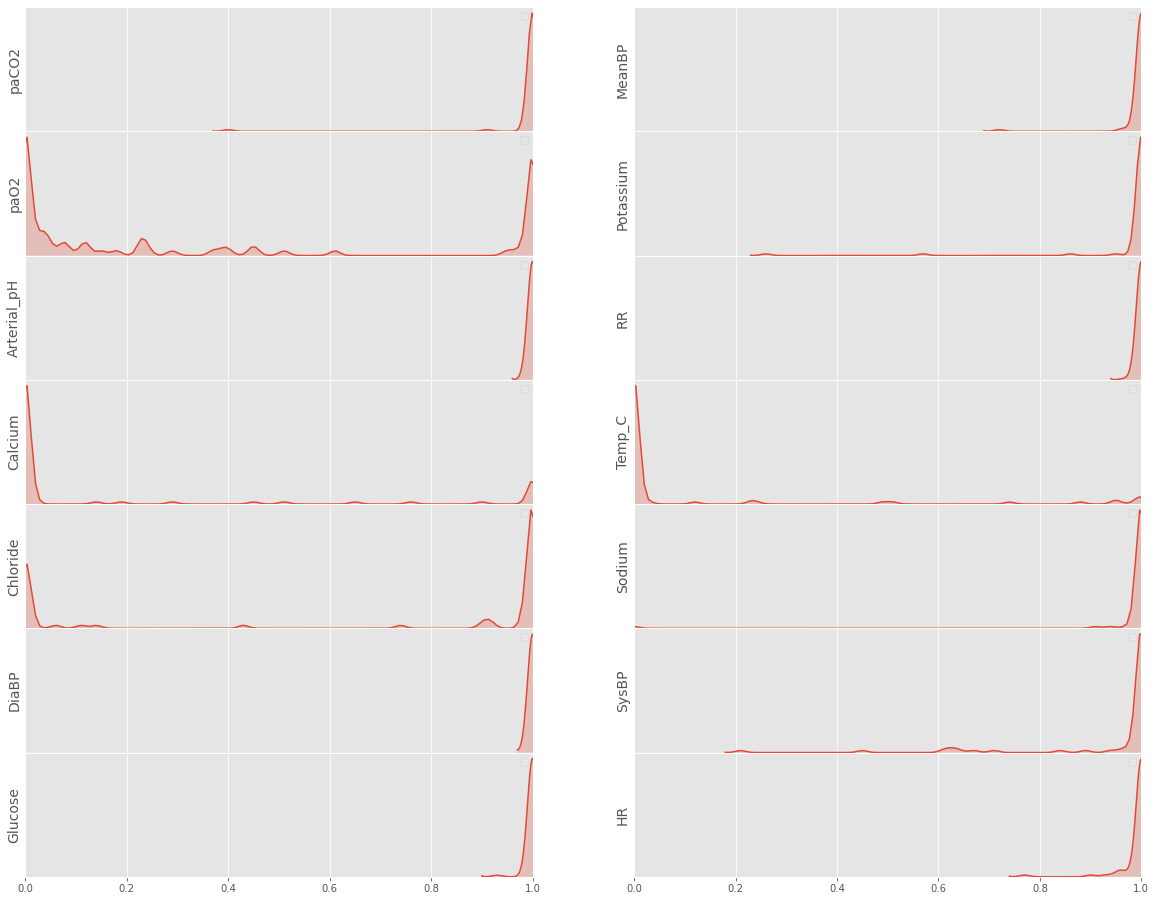

In [24]:
import seaborn as sns
hyp_test_dir = "/data/localhost/taufiq/bootstrap_kmeans/pulse_4_bins/"
x_columns = ['paCO2', 'paO2', 'Arterial_pH', 'Calcium', 'Chloride', 'DiaBP', 'Glucose', 'MeanBP', 'Potassium', 'RR', 'Temp_C', 'Sodium', 'SysBP', 'HR']
fig, axs = plt.subplots(int(len(x_columns)/2), 2, figsize=(20,16), sharex=True)

combined_p_values = pd.DataFrame()
i = 0
for col_name in tqdm(x_columns):
    axis = axs[i% int(len(x_columns)/2)][int(i/(len(x_columns)/2))]
    p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col_name}.csv", converters={'actions': eval, col_name: eval})
    p_values.rename(columns={col_name: 'col_v'}, inplace=True)
    p_values['Outcome'] = col_name
    combined_p_values = combined_p_values.append(p_values, ignore_index=True)
    sns.kdeplot(data=combined_p_values.loc[combined_p_values['Outcome']==col_name, "p"], shade=True, bw=0.01, ax=axis)
    axis.set_ylabel(col_name, fontsize=14)
    axis.set_yticks([])
    axis.legend([])
    i += 1
    
# axis.set_xlabel("$\hat{p}^{{x}, {a}}$ density")
axis.set_xlim([0,1.0])
plt.subplots_adjust(hspace=0)

# fig, axs = plt.subplots(1, figsize=(10,15))    
# sns.catplot(x='p',y='Outcome', data=combined_p_values, ax=axs, kind="boxen")

100%|██████████| 15/15 [00:00<00:00, 320.09it/s]


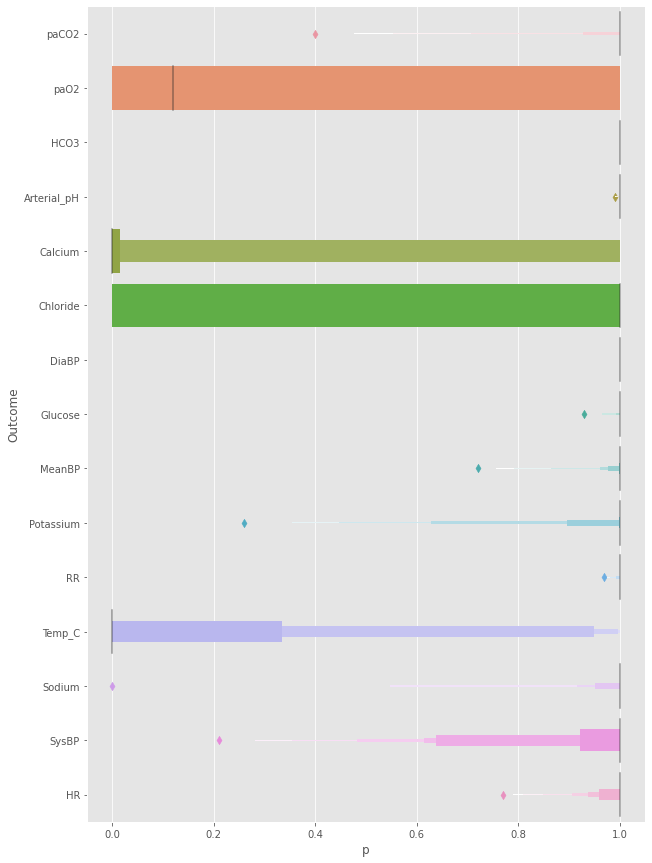

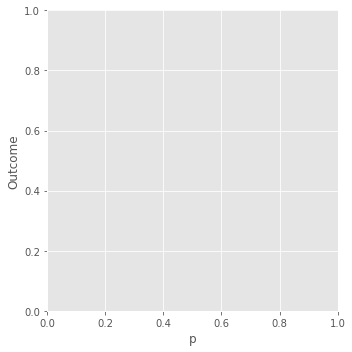

In [20]:
import seaborn as sns
hyp_test_dir = "/data/localhost/taufiq/bootstrap_kmeans/pulse_4_bins/"
x_columns = ['paCO2', 'paO2', 'HCO3', 'Arterial_pH', 'Calcium', 'Chloride', 'DiaBP', 'Glucose', 'MeanBP', 'Potassium', 'RR', 'Temp_C', 'Sodium', 'SysBP', 'HR']
combined_p_values = pd.DataFrame()
for col_name in tqdm(x_columns):
    p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col_name}.csv", converters={'actions': eval, col_name: eval})
    p_values.rename(columns={col_name: 'col_v'}, inplace=True)
    p_values['Outcome'] = col_name
    combined_p_values = combined_p_values.append(p_values, ignore_index=True)

fig, axs = plt.subplots(1, figsize=(10,15))    
sns.catplot(x='p',y='Outcome', data=combined_p_values, ax=axs, kind="boxen")

## Visualise p-values (# bins = 3) 

100%|██████████| 15/15 [00:00<00:00, 103.71it/s]


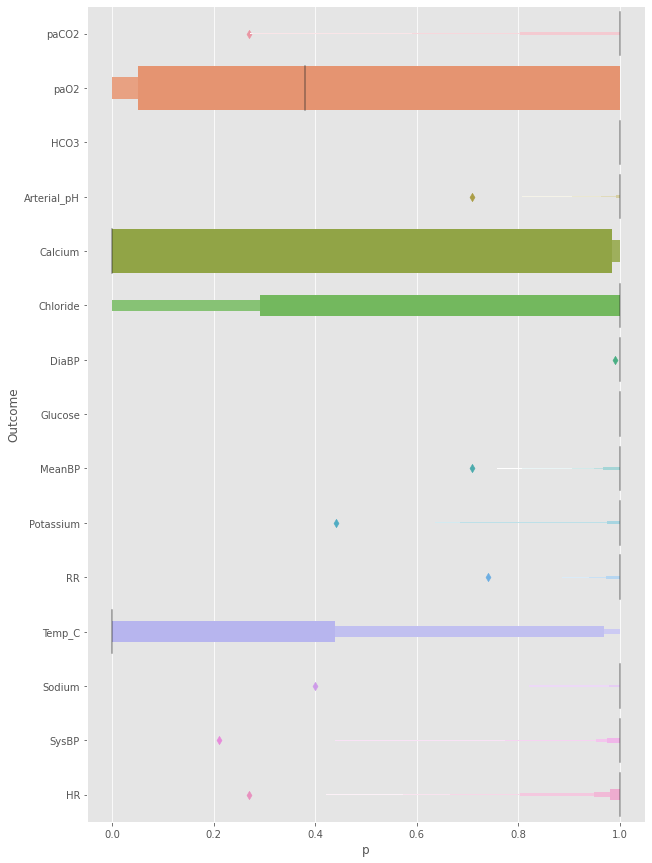

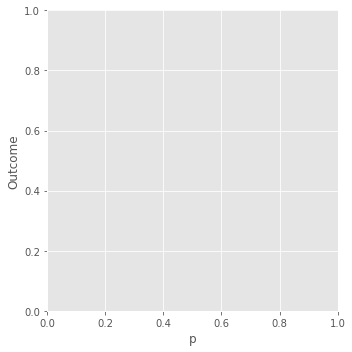

In [70]:
import seaborn as sns
hyp_test_dir = "/data/localhost/taufiq/bootstrap_kmeans/pulse_3_bins/"
x_columns = ['paCO2', 'paO2', 'HCO3', 'Arterial_pH', 'Calcium', 'Chloride', 'DiaBP', 'Glucose', 'MeanBP', 'Potassium', 'RR', 'Temp_C', 'Sodium', 'SysBP', 'HR']
combined_p_values = pd.DataFrame()
for col_name in tqdm(x_columns):
    p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col_name}.csv", converters={'actions': eval, col_name: eval})
    p_values.rename(columns={col_name: 'col_v'}, inplace=True)
    p_values['Outcome'] = col_name
    combined_p_values = combined_p_values.append(p_values, ignore_index=True)

fig, axs = plt.subplots(1, figsize=(10,15))    
sns.catplot(x='p',y='Outcome', data=combined_p_values, ax=axs, kind="boxen")

# Heatmap w.r.t. actions

In [110]:
observational_data['input_1hourly'].max()

9392.623466666668

In [163]:
def get_iv_value(action_bin):
    max_dose = round(observational_data.loc[observational_data['A']==action_bin, 'input_1hourly'].max(), 2)
    min_dose = round(observational_data.loc[observational_data['A']==action_bin, 'input_1hourly'].min(), 2)
    if max_dose == 0:
        return '0'
    min_dose = round(observational_data.loc[(observational_data['A']!=action_bin) & (observational_data['input_1hourly']<=min_dose), 'input_1hourly'].max(), 2)
    if max_dose > 1000:
        return f'> {int(min_dose)}'
    if (min_dose is not np.nan) and (max_dose is not np.nan):
        return f'{int(min_dose)} - {int(max_dose)}'
    return f'{min_dose} - {max_dose}'

def get_vp_value_bins(action_bin):
    max_dose = round(observational_data.loc[observational_data['A']==action_bin, 'median_dose_vaso'].max(), 2)
    min_dose = round(observational_data.loc[observational_data['A']==action_bin, 'median_dose_vaso'].min(), 2)
    if max_dose == 0:
        return '0'
    min_dose = round(observational_data.loc[(observational_data['A']!=action_bin) & (observational_data['median_dose_vaso']<=min_dose), 'median_dose_vaso'].max(), 2)
    if max_dose > 1000:
        return f'> {min_dose}'
    return f'{min_dose} - {max_dose}'

def get_vp_value(action_bin):
    return round(observational_data.loc[observational_data['A']==action_bin, 'median_dose_vaso'].mean(), 2)


In [133]:
import seaborn as sns

def generate_heat_map(outcome):
    fig, axs = plt.subplots(2, 1, figsize=(10,4), sharex=True)
    plt.style.use("fivethirtyeight")
#     hyp_test_dir = "/data/localhost/taufiq/bootstrap_kmeans/pulse_5_bins/"
    hyp_test_dir = "/data/localhost/taufiq/hyp_test_dir_MIMIC_combined/"
    p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{outcome}.csv", converters={'actions': eval, col_name: eval})
    p_values['Med A'] = p_values['actions'].apply(lambda x: np.median(x))
    p_values['IV dose'] = p_values['Med A'].apply(lambda x: get_iv_value(x))
    p_values['VP dose'] = p_values['Med A'].apply(lambda x: get_vp_value(x))
    p_values['MSE'] = round((p_values['Exp_y'] - p_values['Sim_exp_y'])**2, 1)
    pivot_p = p_values[["VP dose", "IV dose", "p"]].pivot_table(index="VP dose", columns="IV dose", values="p", aggfunc=np.mean)
    sns.heatmap(pivot_p, annot=True, fmt='.2f', cmap="mako", ax=axs[0], annot_kws={"fontsize":14})
    axs[0].set_title("$\hat{\mathbb{E}}[CPS(x, a) | A = a]$")
    axs[0].set_xlabel("")
    pivot_mse = p_values[["VP dose", "IV dose", "MSE"]].pivot_table(index="VP dose", columns="IV dose", values="MSE", aggfunc=np.mean)
    axs[1].set_title("$\hat{\mathbb{E}}[(Y^{sim}-Y^{obs})^2 | A = a]$")
    sns.heatmap(pivot_mse, annot=True, fmt='.0f', cmap="mako_r", ax=axs[1], annot_kws={"fontsize":14})
    plt.subplots_adjust(hspace=0.5)

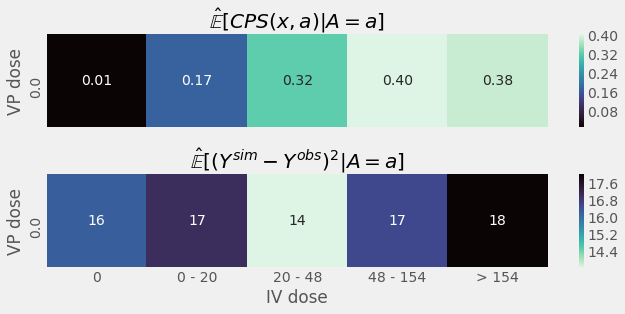

In [139]:
generate_heat_map("Temp_C")

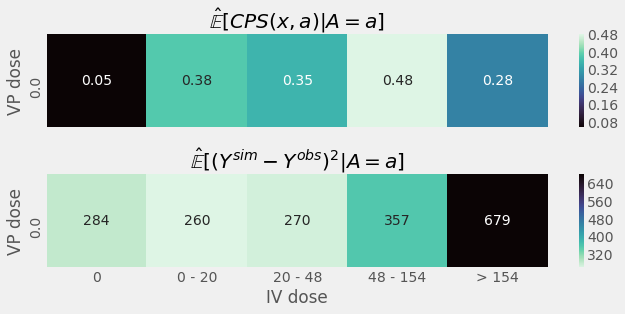

In [140]:
generate_heat_map("Calcium")

# Histogram of action occurences

In [13]:
from sklearn.cluster import KMeans
from scipy.stats import rankdata

logging.info('Creating action bins')
nact = nra**2
input_1hourly_nonzero = observational_data.loc[observational_data['input_1hourly']>0, 'input_1hourly']
iol_ranked = rankdata(input_1hourly_nonzero)/len(input_1hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(observational_data)) # array of ones, by default
io[observational_data['input_1hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = observational_data['max_dose_vaso'].copy()
vc_nonzero = observational_data.loc[observational_data['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [observational_data.loc[io==1, 'input_1hourly'].median(), observational_data.loc[io==2, 'input_1hourly'].median(), observational_data.loc[io==3, 'input_1hourly'].median(), observational_data.loc[io==4, 'input_1hourly'].median(), observational_data.loc[io==5, 'input_1hourly'].median()]
ma2 = [observational_data.loc[vc==1, 'max_dose_vaso'].median(), observational_data.loc[vc==2, 'max_dose_vaso'].median(), observational_data.loc[vc==3, 'max_dose_vaso'].median(), observational_data.loc[vc==4, 'max_dose_vaso'].median(), observational_data.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

In [14]:
def get_iv_dose_for_histogram(io_val):
    max_dose = round(observational_data.loc[io==io_val, 'input_1hourly'].max(), 2)
    min_dose = round(observational_data.loc[io==io_val, 'input_1hourly'].min(), 2)
    if max_dose == 0:
        return '0'
    min_dose = round(observational_data.loc[(io!=io_val) & (observational_data['input_1hourly']<=min_dose), 'input_1hourly'].max(), 2)
    if max_dose > 1000:
        return f'> {int(min_dose)}'
    if (min_dose != float('NaN')) and (max_dose != float('NaN')):
        return f'{int(min_dose)} - {int(max_dose)}'
    return f'{min_dose} - {max_dose}'

def get_vp_dose_for_histogram(vp_val):
    max_dose = observational_data.loc[vc==vp_val, 'max_dose_vaso'].max()
    min_dose = observational_data.loc[vc==vp_val, 'max_dose_vaso'].min()
    if max_dose == 0:
        return '0'
    min_dose = observational_data.loc[(vc!=vp_val) & (observational_data['max_dose_vaso']<=min_dose), 'max_dose_vaso'].max()
    if max_dose > 1:
        return f'> {min_dose}'
    if (min_dose is not np.nan) and (max_dose is not np.nan):
        return f'{min_dose} - {max_dose}'
    return f'{min_dose} - {max_dose}'

In [34]:
observational_data['index'] = pd.Series(observational_data.index)
observational_data['IV_dose'] = pd.Series(io).apply(lambda x: get_iv_dose_for_histogram(x))
observational_data['VP_dose'] = pd.Series(vc).apply(lambda x: get_vp_dose_for_histogram(x))

In [35]:
pivot_table = observational_data.pivot_table(values='index', index='IV_dose', columns='VP_dose', aggfunc=lambda x: len(x.unique()))
pivot_table


VP_dose,0,0.0 - 0.061,0.061 - 0.15,0.15 - 0.313,> 0.313
IV_dose,,,,,
0,19567,406,297,180,183
0 - 20,7596,561,466,330,192
20 - 75,8189,391,474,495,399
75 - 214,8147,233,226,264,351
> 214,6703,447,613,710,965


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '0 - 20'),
  Text(0, 2.5, '20 - 75'),
  Text(0, 3.5, '75 - 214'),
  Text(0, 4.5, '> 214')])

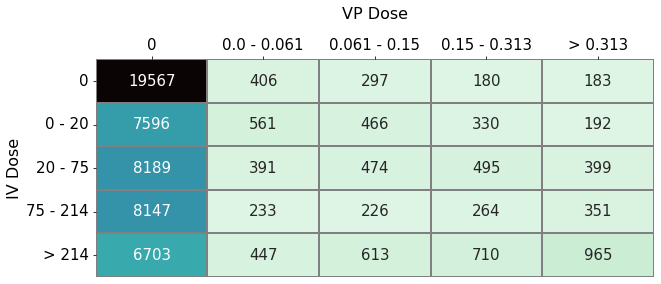

In [90]:
import seaborn as sns

fig, axs = plt.subplots(1, 1, figsize=(10,4))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap="mako_r", ax=axs, annot_kws={"fontsize":15}, cbar=False, linewidths=0.1, linecolor='gray')
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True


plt.xlabel('VP Dose', fontsize=16, labelpad=-270)
plt.ylabel('IV Dose', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(rotation=0, fontsize=15)


<ipython-input-458-94aee18d4bfa>:15: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=15, azim=-55)


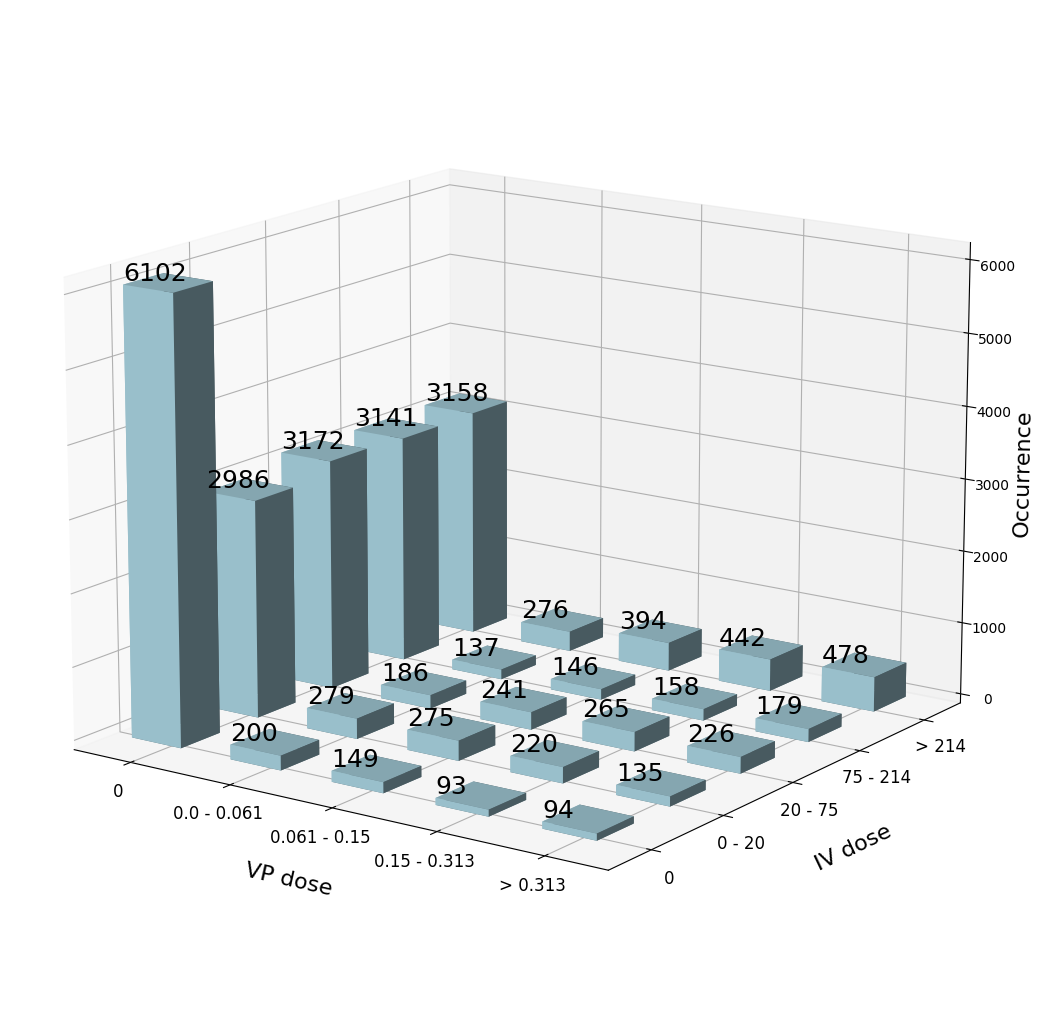

In [458]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
# from matplotlib import style
# style.use('fivethirtyeight')

data = pivot_table.values

column_names = observational_data['VP_dose'].unique()
column_names.sort()
row_names = observational_data['IV_dose'].unique()
row_names.sort()

fig, ax = plt.subplots(figsize = (10,10))
ax = Axes3D(fig, elev=15, azim=-55)

lx= len(data[0])            # Work out matrix dimensions
ly= len(data[:,0])
xpos = np.arange(0,lx,1)    # Set up a mesh of positions
ypos = np.arange(0,ly,1)
xpos, ypos = np.meshgrid(xpos +0.25, ypos+0.25)

xpos = xpos.flatten()   # Convert positions to 1D array
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

# cs = ['r', 'g', 'b', 'y', 'c'] * ly

# ax.bar3d(xpos,ypos,zpos, dx, dy, dz, color=sns.color_palette("mako", 100)[99])
ax.bar3d(xpos,ypos,zpos, dx, dy, dz, color="lightblue")
for x,y,z in zip(xpos,ypos,dz):
    ax.text(x,y,z,'%2.0f'%z, horizontalalignment='left', verticalalignment='bottom', fontsize=18)


#sh()
# ax.w_xaxis.set_ticklabels(column_names)
plt.xticks(np.arange(0.5, 5, 1), column_names, fontsize=12)
# ax.w_yaxis.set_ticklabels(row_names)
plt.yticks(np.arange(0.5, 5, 1), row_names, fontsize=12)
ax.set_zticks(np.array([0,1,2,3,4,5,6])*1000)
ax.set_xlabel('VP dose', fontsize=16, color='black')
ax.set_ylabel('IV dose', fontsize=16, color='black')
ax.set_zlabel('Occurrence', fontsize=16, color='black')
ax.xaxis.labelpad=20
ax.yaxis.labelpad=20
plt.style.use("default")
plt.show()


In [64]:
lx= len(data[0])            # Work out matrix dimensions
ly= len(data[:,0])
xpos = np.arange(0,lx,1)    # Set up a mesh of positions
ypos = np.arange(0,ly,1)

In [72]:
xpos

array([0.9, 1.9, 2.9, 3.9, 4.9, 0.9, 1.9, 2.9, 3.9, 4.9, 0.9, 1.9, 2.9,
       3.9, 4.9, 0.9, 1.9, 2.9, 3.9, 4.9, 0.9, 1.9, 2.9, 3.9, 4.9])

In [35]:
outcome = "Calcium"
p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{outcome}.csv", converters={'actions': eval, col_name: eval})
p_values['Med A'] = p_values['actions'].apply(lambda x: np.median(x))
p_values[p_values['Med A']==3].head()

,Unnamed: 0,actions,age,gender,p,x_t,n_real,n_sim,Med A
0,0,"[3.0, 3.0, 3.0, 3.0]",2.0,0.0,0.00,"[3, 3, 3, 3]",135.0,147.0,3.0
3,3,"[3.0, 3.0, 3.0, 3.0]",4.0,0.0,0.00,"[2, 2, 2, 2]",135.0,200.0,3.0
4,4,"[3.0, 3.0, 3.0, 3.0]",4.0,1.0,0.76,"[3, 3, 3, 3]",96.0,102.0,3.0
5,5,"[3.0, 3.0, 3.0, 3.0]",3.0,0.0,0.00,"[1, 1, 1, 1]",47.0,6.0,3.0
7,7,"[3.0, 3.0, 3.0, 3.0]",4.0,1.0,0.00,"[1, 1, 1, 1]",42.0,2.0,3.0


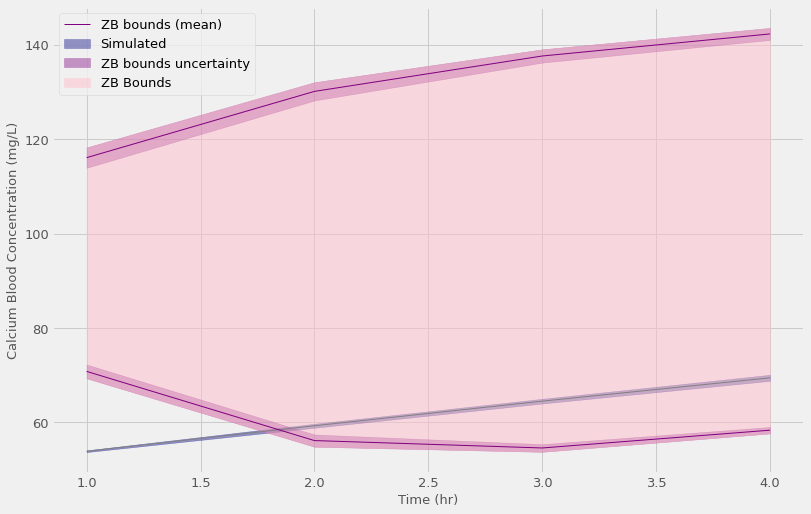

In [36]:
plot_bounds_bootstrap(outcome, 1, 2, [3.0, 3.0, 3.0, 3.0], [3, 3, 3, 3])

# Analysis of bins

In [75]:
hyp_test_dir = "/data/localhost/taufiq/bootstrap_kmeans/pulse_3_bins/"
trajec_actions_with_sofa = pd.read_csv(f"{hyp_test_dir}/trajec_actions.csv", converters={'actions': eval, 'x_t': eval})
MIMIC = pd.read_csv(exportdir + '/MIMIC-1hourly-length-5.csv')

MIMIC_t0 = MIMIC.loc[MIMIC['bloc']==1]
MIMIC_t0 = MIMIC_t0.merge(trajec_actions_with_sofa[['icustay_id', 'x_t']], on=['icustay_id'])
MIMIC_t0['x_t'] = MIMIC_t0['x_t'].apply(lambda x: x[0])

MIMIC_t1 = MIMIC.loc[MIMIC['bloc']==2]
MIMIC_t1 = MIMIC_t1.merge(trajec_actions_with_sofa[['icustay_id', 'x_t']], on=['icustay_id'])
MIMIC_t1['x_t'] = MIMIC_t1['x_t'].apply(lambda x: x[1])

MIMIC_t2 = MIMIC.loc[MIMIC['bloc']==3]
MIMIC_t2 = MIMIC_t2.merge(trajec_actions_with_sofa[['icustay_id', 'x_t']], on=['icustay_id'])
MIMIC_t2['x_t'] = MIMIC_t2['x_t'].apply(lambda x: x[2])

MIMIC_t3 = MIMIC.loc[MIMIC['bloc']==3]
MIMIC_t3 = MIMIC_t3.merge(trajec_actions_with_sofa[['icustay_id', 'x_t']], on=['icustay_id'])
MIMIC_t3['x_t'] = MIMIC_t3['x_t'].apply(lambda x: x[3])

MIMIC_sofa = pd.concat([MIMIC_t0, MIMIC_t1, MIMIC_t2, MIMIC_t3], ignore_index=True).sort_values(by=['icustay_id', 'bloc']).reset_index(drop=True)
MIMIC_sofa.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance,x_t
0,1,14,4.264269e+09,0.0,30946.970000,2.0,0.0,0.0,0.0,1.0,...,0.647399,577.499991,0.00,0.00,0.0,80.000,1263.0,599.0,-1183.000,2
1,2,14,4.264273e+09,0.0,30946.970000,2.0,0.0,0.0,0.0,1.0,...,0.571014,447.499993,0.00,0.00,80.0,1120.000,1837.0,574.0,-637.000,2
2,3,14,4.264276e+09,0.0,30946.970000,2.0,0.0,0.0,0.0,1.0,...,0.446565,447.499993,0.00,0.00,1200.0,80.000,2386.0,549.0,-1106.000,2
3,3,14,4.264276e+09,0.0,30946.970000,2.0,0.0,0.0,0.0,1.0,...,0.446565,447.499993,0.00,0.00,1200.0,80.000,2386.0,549.0,-1106.000,2
4,1,75,5.987178e+09,1.0,30550.009259,3.0,0.0,0.0,0.0,0.0,...,0.845311,123.000000,0.13,0.13,0.0,11.388,10680.0,5115.0,-10668.612,2


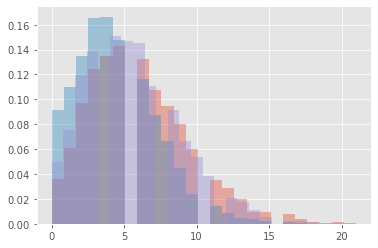

In [82]:
MIMIC_sofa.loc[MIMIC_sofa['x_t']==0, 'SOFA'].hist(bins=25, density=True, alpha=0.4)
MIMIC_sofa.loc[MIMIC_sofa['x_t']==1, 'SOFA'].hist(bins=25, density=True, alpha=0.4)
MIMIC_sofa.loc[MIMIC_sofa['x_t']==2, 'SOFA'].hist(bins=25, density=True, alpha=0.4)

In [79]:
def rej_hyps_age_group(col, gender, age):
    rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, 'x_t': eval})
    trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions.csv", converters={'actions': eval, 'x_t': eval})
    state_actions = trajec_actions[['gender', 'age', 'actions', 'x_t']].copy()
    state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
    state_actions.loc[:,'s'] = state_actions['x_t'].apply(tuple)
    state_actions = state_actions.groupby(by=['gender', 'age', 'a', 's']).filter(lambda x: len(x) >= 10).drop_duplicates(['gender', 'age', 'a', 's'])
    total_hyp = ((state_actions['age']==age)&(state_actions['gender']==gender)).sum()
    rej_hyps_num = ((rej_hyps['age']==age)&(rej_hyps['gender']==gender)).sum()
    return rej_hyps_num/total_hyp*100

In [80]:
rej_hyps_age_group('HR', 0, 4)

0.0

In [81]:
ages = []
for i in range(1, 4):
    age_min = str(int(MIMICtable.loc[MIMICtable['age']==i, 'age_raw'].min()/365))
    age_max = str(int(MIMICtable.loc[MIMICtable['age']==i+1, 'age_raw'].min()/365))
    ages.append(f'{age_min}-{age_max}')
ages.append(f'>{age_max}')

In [84]:
col_name = 'Calcium'
rej_hyps_age = pd.DataFrame()
gend = ['male', 'female']
for gender in [0,1]:
    for age in [1,2,3,4]:
        rh = rej_hyps_age_group(col_name, gender, age)
        rej_hyps_age = rej_hyps_age.append({'gender': gend[gender], 'age': ages[age-1], 'rej_hyps': rh}, ignore_index=True)

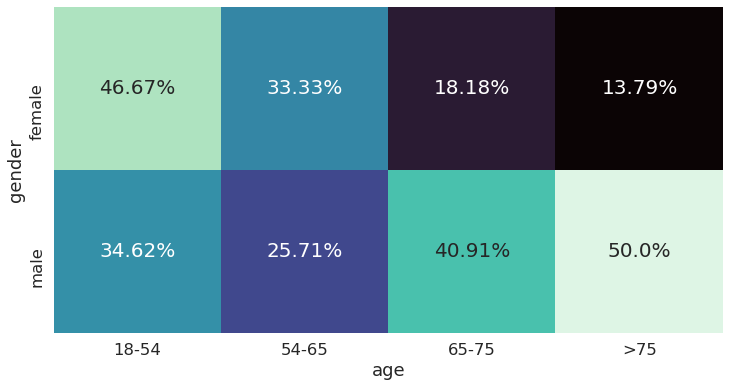

In [85]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize=(12,6))
rej_hyps_age_pivot = rej_hyps_age.pivot_table(index="gender", columns="age", values="rej_hyps", aggfunc=np.min)
sns.set(font_scale=1.5)
labels = np.round(rej_hyps_age_pivot.values,2).astype(str)
for i in range(len(labels)):
    for j in range(len(labels[0])):
        labels[i][j] += '%'
sns.heatmap(rej_hyps_age_pivot, vmax=rej_hyps_age_pivot.values.max(), vmin=rej_hyps_age_pivot.values.min(), annot=labels, fmt='', cmap='mako', ax=axs, annot_kws={"fontsize":20}, cbar=False)

# Divide by severity

In [236]:
import numpy as np
def generate_dataframe_by_severity():
    df = pd.DataFrame()
    for col_name in tqdm(column_names_unit):
        rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
#         print("Rej hyps", len(rej_hyps))
#         print("Trajec actions", len(trajec_actions))
        state_actions_unique = trajec_actions.copy()
        state_actions_unique.loc[:,'a'] = trajec_actions['actions'].apply(tuple)
        state_actions_unique.loc[:,'s'] = trajec_actions[col_name].apply(tuple)
        state_actions_unique = state_actions_unique.drop_duplicates(['gender', 'age', 'a', 's'])
        for index, row in state_actions_unique.iterrows():
            if np.median(row['s']) <= 1:
                state_actions_unique.loc[index, 'Outcome severity'] = 'extremely low'
            elif np.median(row['s']) <= 2:
                state_actions_unique.loc[index, 'Outcome severity'] = 'low'
            elif np.median(row['s']) <= 3:
                state_actions_unique.loc[index, 'Outcome severity'] = 'medium'
            elif np.median(row['s']) <= 4:
                state_actions_unique.loc[index, 'Outcome severity'] = 'high'
            elif np.median(row['s']) <= 5:
                state_actions_unique.loc[index, 'Outcome severity'] = 'very high'
                
        for index, row in rej_hyps.iterrows():
#             print(np.median(row[col_name]))
            if np.median(row[col_name]) <= 1:
                rej_hyps.loc[index, 'Outcome severity'] = 'extremely low'
            elif np.median(row[col_name]) <= 2:
                rej_hyps.loc[index, 'Outcome severity'] = 'low'
            elif np.median(row[col_name]) <= 3:
                rej_hyps.loc[index, 'Outcome severity'] = 'medium'
            elif np.median(row[col_name]) <= 4:
                rej_hyps.loc[index, 'Outcome severity'] = 'high'
            elif np.median(row[col_name]) <= 5:
                rej_hyps.loc[index, 'Outcome severity'] = 'very high'
        for severity in ['extremely low', 'low', 'medium', 'high', 'very high']:
            if len(rej_hyps) > 0:
                df = df.append({'Outcome': col_name, 'Outcome severity': severity, '# rejected hypotheses': (rej_hyps['Outcome severity']==severity).sum(), 'Total # hypotheses': (state_actions_unique['Outcome severity']==severity).sum(), '% rejected': (rej_hyps['Outcome severity']==severity).sum()/(state_actions_unique['Outcome severity']==severity).sum()*100}, ignore_index=True)
            else:
                df = df.append({'Outcome': col_name, 'Outcome severity': severity, '# rejected hypotheses': 0, 'Total # hypotheses': (state_actions_unique['Outcome severity']==severity).sum(), '% rejected': 0}, ignore_index=True)
    return df

In [237]:
df = generate_dataframe_by_severity()

100%|██████████| 16/16 [00:28<00:00,  1.80s/it]


In [238]:
df = df.pivot_table(index=["Outcome"], columns="Outcome severity", values="% rejected", aggfunc=np.max)
df.style.format('{:.1f}').background_gradient(cmap ='viridis')

Outcome severity,extremely low,high,low,medium,very high
Outcome,,,,,
Albumin,0.0,1.1,0.0,0.0,0.0
Arterial_lactate,0.0,0.0,0.0,0.0,0.0
Arterial_pH,0.0,0.0,0.0,0.0,0.0
Calcium,2.6,0.0,0.0,0.0,0.0
Chloride,0.0,0.0,0.0,0.0,0.0
Creatinine,0.0,0.8,0.0,0.0,0.1
DiaBP,0.0,0.0,0.0,0.0,0.0
Glucose,0.0,0.0,0.0,0.0,0.1
HR,0.5,0.2,0.6,0.5,0.3


# Only hypotheses with $n_{obs}\geq 10$ 

In [240]:
state_actions = trajec_actions[['gender', 'age', 'actions', col_name]].copy()
state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
state_actions.loc[:,'s'] = state_actions[col_name].apply(tuple)
state_actions = state_actions.drop_duplicates(['gender', 'age', 'a', 's'])

In [241]:
state_actions

,gender,age,actions,HR,a,s
0,0.0,1.0,"[1.0, 2.0, 3.0, 3.0]","[2.0, 2.0, 2.0, 2.0]","(1.0, 2.0, 3.0, 3.0)","(2.0, 2.0, 2.0, 2.0)"
1,0.0,4.0,"[4.0, 5.0, 4.0, 3.0]","[2.0, 1.0, 1.0, 1.0]","(4.0, 5.0, 4.0, 3.0)","(2.0, 1.0, 1.0, 1.0)"
2,1.0,4.0,"[6.0, 7.0, 7.0, 8.0]","[3.0, 2.0, 2.0, 2.0]","(6.0, 7.0, 7.0, 8.0)","(3.0, 2.0, 2.0, 2.0)"
3,0.0,2.0,"[1.0, 1.0, 1.0, 1.0]","[4.0, 4.0, 4.0, 4.0]","(1.0, 1.0, 1.0, 1.0)","(4.0, 4.0, 4.0, 4.0)"
4,0.0,2.0,"[3.0, 3.0, 3.0, 3.0]","[2.0, 3.0, 2.0, 2.0]","(3.0, 3.0, 3.0, 3.0)","(2.0, 3.0, 2.0, 2.0)"
...,...,...,...,...,...,...
6171,0.0,1.0,"[1.0, 1.0, 1.0, 1.0]","[1.0, 4.0, 5.0, 2.0]","(1.0, 1.0, 1.0, 1.0)","(1.0, 4.0, 5.0, 2.0)"
6172,1.0,4.0,"[2.0, 2.0, 2.0, 2.0]","[3.0, 3.0, 2.0, 2.0]","(2.0, 2.0, 2.0, 2.0)","(3.0, 3.0, 2.0, 2.0)"
6174,0.0,4.0,"[1.0, 1.0, 5.0, 5.0]","[3.0, 3.0, 3.0, 3.0]","(1.0, 1.0, 5.0, 5.0)","(3.0, 3.0, 3.0, 3.0)"
6175,1.0,2.0,"[1.0, 1.0, 1.0, 1.0]","[1.0, 4.0, 5.0, 4.0]","(1.0, 1.0, 1.0, 1.0)","(1.0, 4.0, 5.0, 4.0)"


In [242]:
def filtered_rejected_hypotheses():
    df = pd.DataFrame()
    all_rej_hyps = pd.DataFrame()
    all_hyps = pd.DataFrame()
    for col_name in tqdm(column_names_unit):
        rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
        sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
        if len(rej_hyps)>0:
#             rej_hyps = rej_hyps[(rej_hyps['n_real']>=10)&(rej_hyps['n_sim']>=10)]
            rej_hyps = rej_hyps[(rej_hyps['n_real']>=10)]
            state_actions = trajec_actions[['gender', 'age', 'actions', col_name]].copy()
            state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
            state_actions.loc[:,'s'] = state_actions[col_name].apply(tuple)
            trajec_actions.loc[:,'a'] = trajec_actions['actions'].apply(tuple)
            trajec_actions.loc[:,'s'] = trajec_actions[col_name].apply(tuple)
            sim_trajec_actions.loc[:,'a'] = sim_trajec_actions['actions'].apply(tuple)
            sim_trajec_actions.loc[:,'s'] = sim_trajec_actions[col_name].apply(tuple)
            state_actions = state_actions.drop_duplicates(['gender', 'age', 'a', 's'])
            for index, row in state_actions.iterrows():
                state_actions.loc[index, 'n_real'] = ((trajec_actions['gender']==row['gender']) & (trajec_actions['age']==row['age']) & (trajec_actions['a']==row['a']) & (trajec_actions['s']==row['s'])).sum()
                state_actions.loc[index, 'n_sim'] = ((sim_trajec_actions['gender']==row['gender']) & (sim_trajec_actions['age']==row['age']) & (sim_trajec_actions['a']==row['a']) & (sim_trajec_actions['s']==row['s'])).sum()
#             state_actions = state_actions[(state_actions['n_real']>=10)&(state_actions['n_sim']>=10)]
            state_actions = state_actions[(state_actions['n_real']>=10)]
        df = df.append({'Outcome Y': col_name, '# rejected hypotheses': len(rej_hyps), 'Total # hypotheses': len(state_actions)}, ignore_index=True)
        rej_hyps['col_name'] = col_name
        state_actions['col_name'] = col_name
        all_rej_hyps = all_rej_hyps.append(rej_hyps, ignore_index=True)
        all_hyps = all_hyps.append(state_actions, ignore_index=True)
    return df, all_rej_hyps, all_hyps

In [243]:
df, all_rej_hyps, all_hyps = filtered_rejected_hypotheses()

100%|██████████| 16/16 [01:51<00:00,  6.96s/it]


In [244]:
df.head()

,# rejected hypotheses,Outcome Y,Total # hypotheses
0,8.0,Albumin,38.0
1,0.0,Arterial_pH,38.0
2,0.0,Arterial_lactate,38.0
3,1.0,Calcium,31.0
4,0.0,Chloride,31.0


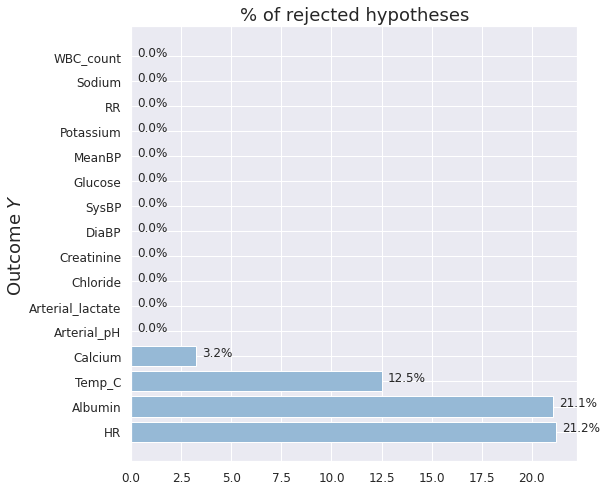

In [245]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
df['% rejected'] = df['# rejected hypotheses']/df['Total # hypotheses']*100
df.sort_values('% rejected', ascending=False, inplace=True)
ax.barh(df['Outcome Y'],df['% rejected'],  color='#96b9d6')
y = df['% rejected']
for i, v in enumerate(y):
    ax.text(v + 0.3, i, "{:.1f}%".format(v), fontsize=12)

plt.title('% of rejected hypotheses')
plt.ylabel('Outcome $Y$')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.style.use('ggplot')
plt.show()

In [246]:
def rej_hyps_age_group(col, gender, age):
    state_actions = all_hyps[all_hyps['col_name']==col]
    rej_hyps = all_rej_hyps[all_rej_hyps['col_name']==col]
    total_hyp = ((state_actions['age']==age)&(state_actions['gender']==gender)).sum()
    rej_hyps_num = ((rej_hyps['age']==age)&(rej_hyps['gender']==gender)).sum()
    if total_hyp > 0:
        return rej_hyps_num/total_hyp*100
    return 0

In [247]:
def plot_heatmap(col_name):
    rej_hyps_age = pd.DataFrame()
    gend = ['male', 'female']
    for gender in [0,1]:
        for age in [1,2,3,4]:
            rh = rej_hyps_age_group(col_name, gender, age)
            rej_hyps_age = rej_hyps_age.append({'gender': gend[gender], 'age': ages[age-1], 'rej_hyps': rh}, ignore_index=True)
    fig, axs = plt.subplots(1, figsize=(12,6))
    rej_hyps_age_pivot = rej_hyps_age.pivot_table(index="gender", columns="age", values="rej_hyps", aggfunc=np.min)
    sns.set(font_scale=1.5)
    labels = np.round(rej_hyps_age_pivot.values,2).astype(str)
    for i in range(len(labels)):
        for j in range(len(labels[0])):
            labels[i][j] += '%'
    sns.heatmap(rej_hyps_age_pivot, vmax=rej_hyps_age_pivot.values.max(), vmin=rej_hyps_age_pivot.values.min(), annot=labels, fmt='', cmap='mako', ax=axs, annot_kws={"fontsize":20}, cbar=False)

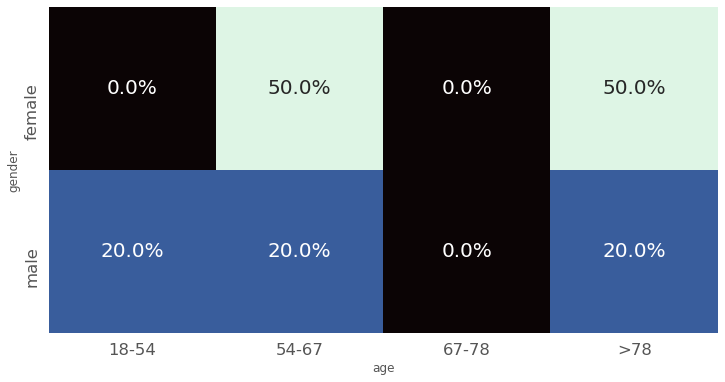

In [248]:
plot_heatmap('HR')

In [249]:
combined_p_values.head()

,Unnamed: 0,col_v,actions,age,gender,p,Outcome
0,0,"[4.0, 4.0, 4.0, 4.0]","[1.0, 1.0, 1.0, 1.0]",1.0,1.0,0.0,Albumin
1,1,"[4.0, 4.0, 4.0, 4.0]","[1.0, 1.0, 1.0, 1.0]",3.0,0.0,0.0,Albumin
2,2,"[4.0, 4.0, 4.0, 4.0]","[1.0, 1.0, 1.0, 1.0]",4.0,0.0,0.0,Albumin
3,3,"[4.0, 4.0, 4.0, 4.0]","[1.0, 1.0, 1.0, 1.0]",2.0,0.0,0.0,Albumin
4,4,"[4.0, 4.0, 4.0, 4.0]","[1.0, 1.0, 1.0, 2.0]",3.0,0.0,0.0,Albumin


In [212]:
def generate_violin_plots(hyp_test_dir):
    combined_df = pd.DataFrame()
    for col_name in tqdm(column_names_unit):
        if col_name in all_hyps:
            rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, col_name: eval})
            trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
            sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})

            rej_hyps_filtered = all_rej_hyps[all_rej_hyps['col_name']==col_name].copy()
            all_hyps_filtered = all_hyps[all_hyps['col_name']==col_name].copy()
            all_hyps_filtered = all_hyps_filtered[[col_name, 'gender', 'age', 'actions']].copy()
            all_hyps_filtered['gamma'] = all_hyps_filtered.apply(lambda x: compute_probs(trajec_actions, col_name, x[0], x[1], x[2], x[3])[-1], axis=1)            

            non_rej_hyps = pd.DataFrame()
            for index, row in all_hyps_filtered.iterrows():
                 if ((rej_hyps_filtered['gender']==row['gender']) & (rej_hyps_filtered['age']==row['age']) & (rej_hyps_filtered[col_name].apply(tuple)==tuple(row[col_name])) & (rej_hyps_filtered['actions'].apply(tuple)==tuple(row['actions']))).sum() == 0:
                        non_rej_hyps = non_rej_hyps.append(row, ignore_index=True)

            non_rej_hyps['Outcome'] = f'{col_name}'+'$_{a}$'
            if len(rej_hyps_filtered) > 0:
                rej_hyps_filtered = rej_hyps_filtered[[col_name, 'gender', 'age', 'actions']]
                rej_hyps_filtered['gamma'] = rej_hyps_filtered.apply(lambda x: compute_probs(trajec_actions, col_name, x[0], x[1], x[2], x[3])[-1], axis=1)
                rej_hyps_filtered['Outcome'] = f'{col_name}' + '$_{r}$'
                combined = non_rej_hyps[['Outcome', 'gamma']].merge(rej_hyps_filtered[['Outcome', 'gamma']], left_on=['Outcome', 'gamma'], right_on=['Outcome', 'gamma'], how='outer')
            else:
                combined = non_rej_hyps[['Outcome', 'gamma']]
            combined_df = combined_df.append(combined, ignore_index=True)
    return combined_df

In [213]:
combined_df = generate_violin_plots(hyp_test_dir)

100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


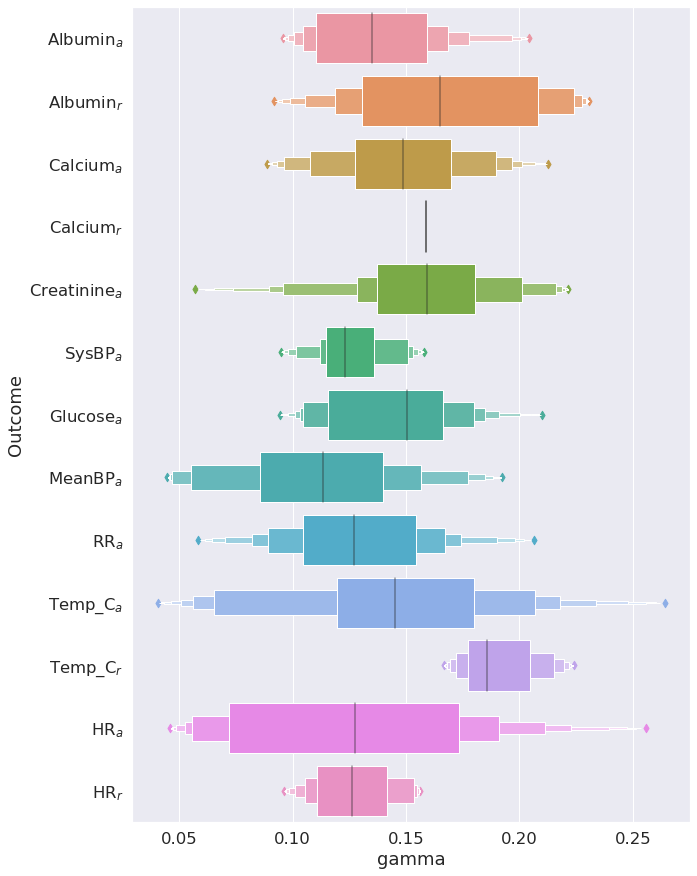

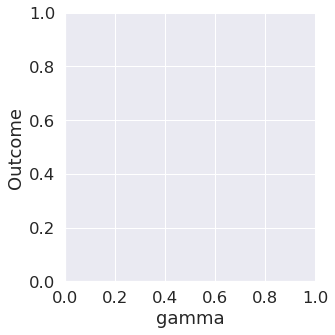

In [221]:
fig, axs = plt.subplots(1, figsize=(10,15))
sns.catplot(x='gamma',y='Outcome', data=combined_df, ax=axs, kind="boxen")

In [250]:
def plot_combined_heatmap():
    rej_hyps_all = pd.DataFrame()
#     fig, axs = plt.subplots(len(column_names_dict),1, figsize=(12,36))
    columns = list(column_names_dict.keys())
    for index in range(len(column_names_dict)):
        col_name = columns[index]
        rej_hyps_age = pd.DataFrame()
        gend = ['M', 'F']
        for gender in [0,1]:
            for age in [1,2,3,4]:
                rh = rej_hyps_age_group(col_name, gender, age)
                rej_hyps_age = rej_hyps_age.append({'gender': gend[gender], 'age': ages[age-1], 'rej_hyps': rh}, ignore_index=True)
        rej_hyps_age['Outcome'] = col_name
        rej_hyps_all = rej_hyps_all.append(rej_hyps_age, ignore_index=True)
        rej_hyps_age_pivot = rej_hyps_age.pivot_table(index="gender", columns="age", values="rej_hyps", aggfunc=np.min)
        sns.set(font_scale=1.5)
        labels = np.round(rej_hyps_age_pivot.values,2).astype(str)
        for i in range(len(labels)):
            for j in range(len(labels[0])):
                labels[i][j] += '%'
#         sns.heatmap(rej_hyps_age_pivot, vmax=rej_hyps_age_pivot.values.max(), vmin=rej_hyps_age_pivot.values.min(), annot=labels, fmt='', cmap='mako', ax=axs[index], annot_kws={"fontsize":20}, cbar=False)
    return rej_hyps_all

In [251]:
# pd.options.display.float_format = "{:,.2f}".format
# df = df.round(2)
df = plot_combined_heatmap()
df = df.pivot_table(index=["Outcome","gender"], columns="age", values="rej_hyps", aggfunc=np.min)
df.style.format('{:.0f}').background_gradient(cmap ='viridis')

In [252]:
# df.style.format('{:.0f}')
df = df.loc[df.sum(axis=1)>0, :]
df.style.format('{:.0f}').background_gradient(cmap ='viridis')

# Divide by severity

In [253]:
import numpy as np
def generate_dataframe_by_severity():
    df = pd.DataFrame()
    for col_name in tqdm(column_names_unit):
        rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
        sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
        if len(rej_hyps)>0:
#             rej_hyps = rej_hyps[(rej_hyps['n_real']>=10)&(rej_hyps['n_sim']>=10)]
            rej_hyps = rej_hyps[(rej_hyps['n_real']>=10)]
            state_actions = trajec_actions[['gender', 'age', 'actions', col_name]].copy()
            state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
            state_actions.loc[:,'s'] = state_actions[col_name].apply(tuple)
            trajec_actions.loc[:,'a'] = trajec_actions['actions'].apply(tuple)
            trajec_actions.loc[:,'s'] = trajec_actions[col_name].apply(tuple)
            sim_trajec_actions.loc[:,'a'] = sim_trajec_actions['actions'].apply(tuple)
            sim_trajec_actions.loc[:,'s'] = sim_trajec_actions[col_name].apply(tuple)
            state_actions = state_actions.drop_duplicates(['gender', 'age', 'a', 's'])
            for index, row in state_actions.iterrows():
                state_actions.loc[index, 'n_real'] = ((trajec_actions['gender']==row['gender']) & (trajec_actions['age']==row['age']) & (trajec_actions['a']==row['a']) & (trajec_actions['s']==row['s'])).sum()
                state_actions.loc[index, 'n_sim'] = ((sim_trajec_actions['gender']==row['gender']) & (sim_trajec_actions['age']==row['age']) & (sim_trajec_actions['a']==row['a']) & (sim_trajec_actions['s']==row['s'])).sum()
#             state_actions = state_actions[(state_actions['n_real']>=10)&(state_actions['n_sim']>=10)]
            state_actions = state_actions[(state_actions['n_real']>=10)]

        for index, row in state_actions.iterrows():
            if np.median(row['s']) <= 1:
                state_actions.loc[index, 'Outcome severity'] = 'extremely low'
            elif np.median(row['s']) <= 2:
                state_actions.loc[index, 'Outcome severity'] = 'low'
            elif np.median(row['s']) <= 3:
                state_actions.loc[index, 'Outcome severity'] = 'medium'
            elif np.median(row['s']) <= 4:
                state_actions.loc[index, 'Outcome severity'] = 'high'
            elif np.median(row['s']) <= 5:
                state_actions.loc[index, 'Outcome severity'] = 'very high'
                
        for index, row in rej_hyps.iterrows():
#             print(np.median(row[col_name]))
            if np.median(row[col_name]) <= 1:
                rej_hyps.loc[index, 'Outcome severity'] = 'extremely low'
            elif np.median(row[col_name]) <= 2:
                rej_hyps.loc[index, 'Outcome severity'] = 'low'
            elif np.median(row[col_name]) <= 3:
                rej_hyps.loc[index, 'Outcome severity'] = 'medium'
            elif np.median(row[col_name]) <= 4:
                rej_hyps.loc[index, 'Outcome severity'] = 'high'
            elif np.median(row[col_name]) <= 5:
                rej_hyps.loc[index, 'Outcome severity'] = 'very high'
        for severity in ['extremely low', 'low', 'medium', 'high', 'very high']:
            if len(rej_hyps) > 0:
                df = df.append({'Outcome': col_name, 'Outcome severity': severity, '# rejected hypotheses': (rej_hyps['Outcome severity']==severity).sum(), 'Total # hypotheses': (state_actions['Outcome severity']==severity).sum(), '% rejected': (rej_hyps['Outcome severity']==severity).sum()/(state_actions['Outcome severity']==severity).sum()*100}, ignore_index=True)
            else:
                df = df.append({'Outcome': col_name, 'Outcome severity': severity, '# rejected hypotheses': 0, 'Total # hypotheses': (state_actions['Outcome severity']==severity).sum(), '% rejected': 0}, ignore_index=True)
    return df

In [254]:
df = generate_dataframe_by_severity()

100%|██████████| 16/16 [01:49<00:00,  6.86s/it]


In [255]:
df = df.pivot_table(index=["Outcome"], columns="Outcome severity", values="% rejected", aggfunc=np.max)
df.style.format('{:.1f}').background_gradient(cmap ='viridis')

Outcome severity,extremely low,high,low,medium,very high
Outcome,,,,,
Albumin,0.0,100.0,0.0,0.0,0.0
Arterial_lactate,0.0,0.0,0.0,0.0,0.0
Arterial_pH,0.0,0.0,0.0,0.0,0.0
Calcium,33.3,0.0,0.0,0.0,0.0
Chloride,0.0,0.0,0.0,0.0,0.0
Creatinine,0.0,0.0,0.0,0.0,0.0
DiaBP,0.0,0.0,0.0,0.0,0.0
Glucose,0.0,0.0,0.0,0.0,0.0
HR,0.0,0.0,75.0,66.7,0.0


# Dividing by SOFA scores

In [82]:
def rej_hyps_by_sofa(col, gender, age):
    sofa_df = pd.DataFrame()
    sofa_vals = ['x<=6', '6<x<=12', '12<x<=18', 'x>18']
    for sofa in range(4):
#         hyp_test_dir = "/data/localhost/taufiq/hyp-test-dir-pulse-trajecs-sofa"
        hyp_test_dir = "/data/localhost/taufiq/bootstrap-updated/pulse_trajecs_sofa"
        rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_sofabin_{sofa}_{col}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_sofabin_{sofa}_{col}.csv", converters={'actions': eval, col_name: eval})
        sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_sofabin_{sofa}_{col}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions.loc[:,'s'] = trajec_actions[col].apply(tuple)
        trajec_actions.loc[:,'a'] = trajec_actions['actions'].apply(tuple)
        trajec_actions = trajec_actions[(trajec_actions['gender']==gender) & (trajec_actions['age']==age)]
        sim_trajec_actions.loc[:,'s'] = sim_trajec_actions[col].apply(tuple)
        sim_trajec_actions.loc[:,'a'] = sim_trajec_actions['actions'].apply(tuple)
        sim_trajec_actions = sim_trajec_actions[(sim_trajec_actions['gender']==gender) & (sim_trajec_actions['age']==age)]
        for index, row in trajec_actions.iterrows():
                trajec_actions.loc[index, 'n_real'] = ((trajec_actions['gender']==row['gender']) & (trajec_actions['age']==row['age']) & (trajec_actions['a']==row['a']) & (trajec_actions['s']==row['s'])).sum()
                trajec_actions.loc[index, 'n_sim'] = ((sim_trajec_actions['gender']==row['gender']) & (sim_trajec_actions['age']==row['age']) & (sim_trajec_actions['a']==row['a']) & (sim_trajec_actions['s']==row['s'])).sum()
        trajec_actions = trajec_actions.drop_duplicates(['gender', 'age', 'a', 's'])
        sim_trajec_actions = sim_trajec_actions.drop_duplicates(['gender', 'age', 'a', 's'])
        if len(trajec_actions) > 0:
            trajec_actions = trajec_actions[(trajec_actions['n_real']>=5)]
#             trajec_actions = trajec_actions[(trajec_actions['n_real']>=10)&(trajec_actions['n_sim']>=10)]
        if len(rej_hyps)>0:
#             rej_hyps = rej_hyps[(rej_hyps['n_real']>=10) & (rej_hyps['n_sim']>=10)]
            rej_hyps = rej_hyps[(rej_hyps['n_real']>=5)]
            rej_hyps = rej_hyps[(rej_hyps['gender']==gender) & (rej_hyps['age']==age)]
        if len(trajec_actions)==0:
            sofa_df = sofa_df.append({'SOFA': sofa_vals[sofa], '# rejected hypotheses': len(rej_hyps), 'Total # hypotheses': len(trajec_actions), '% rejected': float('nan')}, ignore_index=True)
        else:
            sofa_df = sofa_df.append({'SOFA': sofa_vals[sofa], '# rejected hypotheses': len(rej_hyps), 'Total # hypotheses': len(trajec_actions), '% rejected': len(rej_hyps)/len(trajec_actions)*100}, ignore_index=True)
    return sofa_df

In [83]:
col = "Sodium"
rej_hyps_by_sofa(col, 0,4)

,# rejected hypotheses,% rejected,SOFA,Total # hypotheses
0,1.0,14.285714,x<=6,7.0
1,1.0,33.333333,6<x<=12,3.0
2,0.0,NaN,12<x<=18,0.0
3,0.0,NaN,x>18,0.0


In [84]:
hyp_test_dir = "/data/localhost/taufiq/bootstrap-updated/pulse_trajecs_sofa"
nums = pd.read_csv(f"{hyp_test_dir}/rej_hyp_nums.csv")
nums.loc[:, '% rejected'] = nums['# rejected hypotheses']/nums['Total # hypotheses']*100
nums = nums.pivot_table(index=["Outcome Y"], columns="SOFA bin", values="% rejected", aggfunc=np.max)
# nums.style.format('{:.1f}').background_gradient(cmap ='viridis')
nums.style.format('{:.1f}').background_gradient(cmap ='viridis')

SOFA bin,0,1,2,3
Outcome Y,,,,
Albumin,0.0,0.2,0.0,0.0
Arterial_lactate,1.4,0.9,0.0,0.0
Arterial_pH,0.3,0.1,0.4,0.0
Calcium,6.8,3.3,0.4,0.0
Chloride,1.8,1.1,0.4,0.0
Creatinine,0.3,0.4,0.0,0.0
DiaBP,0.0,0.0,0.0,0.0
Glucose,0.0,0.1,0.0,0.0
HCO3,0.1,0.0,0.4,0.0


In [85]:
hyp_test_dir = "/data/localhost/taufiq/bootstrap-updated/pulse_trajecs_sofa"
nums = pd.read_csv(f"{hyp_test_dir}/rej_hyp_nums.csv")
nums[nums['SOFA bin'] == 0]

,Outcome Y,# rejected hypotheses,Total # hypotheses,SOFA bin
114,WBC_count,41,3102,0
115,Sodium,42,2913,0
116,DiaBP,1,3229,0
117,Creatinine,7,3056,0
118,SysBP,5,3206,0
119,RR,1,3255,0
120,Arterial_lactate,40,2955,0
121,Chloride,53,2933,0
122,Sodium,42,2913,0
123,Glucose,1,3042,0


# Average doses

In [86]:
def average_doses(actions):
    iv_avg = 0
    vc_avg = 0
    for a in actions:
        iv_avg += uniqueValueDoses.loc[a-1, 'IV']
        vc_avg += uniqueValueDoses.loc[a-1, 'VC']
    return iv_avg/len(actions), vc_avg/len(actions)

In [87]:
def rej_hyps_age_group_plot_doses(col, gender, age):
    
    for index, row in all_hyps.iterrows():
        all_hyps.at[index,'Avg IV'], all_hyps.at[index, 'Avg VC'] = average_doses(np.array(row['actions']))
#     rej_hyps = all_rej_hyps[all_rej_hyps['col_name']==col]
#     total_hyp = ((state_actions['age']==age)&(state_actions['gender']==gender)).sum()
#     rej_hyps_num = ((rej_hyps['age']==age)&(rej_hyps['gender']==gender)).sum()
    
    iv_nonzero = all_hyps.loc[all_hyps['Avg IV']>0, 'Avg IV']    
    iv_ranked = rankdata(iv_nonzero)/len(iv_nonzero) # excludes zero fluid (will be action 1)
    iv_f = np.floor((iv_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
    iv = np.ones(len(all_hyps)) # array of ones, by default
    iv[all_hyps['Avg IV']>0] = iv_f + 1 # where more than zero fluid given: save actual action
    all_hyps['IV'] = iv
    
    vc_nonzero = all_hyps.loc[all_hyps['Avg VC']>0, 'Avg VC']    
    vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero) # excludes zero fluid (will be action 1)
    vc_f = np.floor((vc_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
    vc = np.ones(len(all_hyps)) # array of ones, by default
    vc[all_hyps['Avg VC']>0] = vc_f + 1 # where more than zero fluid given: save actual action
    all_hyps['VC'] = vc
    return all_hyps
    
    ivs = []
    for i in range(1, 4):
        iv_min = str(int(all_hyps.loc[all_hyps['IV']==i, 'Avg IV'].min()))
        iv_max = str(int(all_hyps.loc[all_hyps['IV']==i+1, 'Avg IV'].min()))
        ivs.append(f'{iv_min}-{iv_max}')
    ivs.append(f'>{iv_max}')
    
    vcs = []
    for i in range(1, 4):
        vc_min = str(int(all_hyps.loc[all_hyps['VC']==i, 'Avg VC'].min()))
        vc_max = str(int(all_hyps.loc[all_hyps['VC']==i+1, 'Avg VC'].min()))
        vcs.append(f'{vc_min}-{vc_max}')
    vcs.append(f'>{vc_max}')
    
    state_actions = all_hyps[all_hyps['col_name']==col]

    for index, row in state_actions.iterrows():
        state_actions.at[index, 'IV_avg_dose'] = ivs[row['IV']-1]
        state_actions.at[index, 'VC_avg_dose'] = vcs[row['VC']-1]   
    return state_actions
    
#     if total_hyp > 0:
#         return rej_hyps_num/total_hyp*100
#     return 0

In [88]:
df = rej_hyps_age_group_plot_doses('Temp_C', 1, 3)
# len(df)
# df = df[df['col_name']=='Temp_C']
# df[['']].pivot_table()

In [89]:
state_actions = all_hyps[all_hyps['col_name']=='Temp_C']

In [90]:
average_doses(np.array(state_actions['actions'].values[0])*2)

(10.0, 0.0)

In [91]:
actionbloc.head()

,action_bloc
0,1
1,2
2,3
3,3
4,3


In [92]:
med.head()

,IV,VC
0,1,1
1,2,1
2,3,1
3,3,1
4,3,1


In [93]:
uniqueValues.head()

,IV,VC
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


## Plotting the reasonable worst case thresholds

In [184]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import rankdata

column_names_unit = {
    'Albumin': 'Albumin Blood Concentration (mg/L)',
    'paCO2': 'Arterial $CO_2$ Pressure (mmHg)',
    'paO2': 'Arterial $O_2$ Pressure (mmHg)',
    'HCO3': 'Bicarbonate Blood Concentration (mg/L)',
    'Arterial_pH': 'Arterial pH',
    'Arterial_lactate': 'Lactate Blood Concentration (mg/L)',
    'Calcium': 'Calcium Blood Concentration (mg/L)',
    'Chloride': 'Chloride Blood Concentration (mg/L)',
    'Creatinine': 'Creatinine Blood Concentration (mg/L)',
    'DiaBP': 'Diastolic Arterial Pressure (mmHg)',
    'SysBP': 'Systolic Arterial Pressure (mmHg)',
    'Glucose': 'Glucose Blood Concentration (mg/L)',
    'MeanBP': 'Mean Arterial Pressure (mmHg)',
    'Potassium': 'Potassium Blood Concentration (mg/L)',
    'RR': 'Respiration Rate (1/min)',
    'Temp_C': 'Skin Temperature (C)',
    'Sodium': 'Sodium Blood Concentration (mg/L)',
    'WBC_count': 'White Blood Cell Count (ct/uL)',
    'HR': 'Heart Rate (1/min)'
}

In [185]:
data_dir = "/data/localhost/taufiq/bootstrap_kmeans/pulse_5_bins_with_K_vals/"
col_name = "Temp_C"

In [186]:
p_values = pd.read_csv(f"{data_dir}/p_values_{col_name}.csv", converters={'actions': eval, 'x_t': eval, 'M_0.05_quantiles': eval, 'M_0.95_quantiles': eval})
p_values.head()

,Unnamed: 0,Exp_y,M_0.05_quantiles,M_0.95_quantiles,Sim_exp_y,actions,age,gender,p,x_t,n_real,n_sim
0,0,36.807737,"[27.556770427909633, 29.48391809704252, 31.160...","[28.642263919999692, 30.192285496532485, 31.64...",32.634864,"[3.0, 3.0, 3.0, 3.0]",2.0,0.0,0.00,"[3, 3, 3, 3]",135.0,147.0
1,1,36.926229,"[32.03937936719265, 31.519072988575545, 32.132...","[32.968369774615084, 32.5387848463641, 32.7713...",32.545502,"[5.0, 5.0, 5.0, 5.0]",2.0,0.0,0.30,"[3, 3, 3, 3]",10.0,12.0
2,2,37.278691,"[33.100838150015306, 32.373830728637934, 33.02...","[34.0124889723665, 33.71664768012768, 33.98406...",33.718153,"[2.0, 2.0, 2.0, 2.0]",2.0,0.0,0.98,"[3, 3, 3, 3]",21.0,5.0
3,3,36.541931,"[26.703317864824736, 28.37173292973465, 30.022...","[27.87432843749355, 28.958900172549214, 30.504...",31.655495,"[3.0, 3.0, 3.0, 3.0]",4.0,0.0,0.00,"[2, 2, 2, 2]",135.0,200.0
4,4,36.661562,"[30.347531545121154, 31.892016943915962, 32.76...","[31.222713889177644, 32.369752933853654, 33.14...",33.704216,"[3.0, 3.0, 3.0, 3.0]",4.0,1.0,0.00,"[3, 3, 3, 3]",96.0,102.0


In [189]:
def plot_M_quantiles(col, gender, age, action, column_v, axis=None):
#     global trajec_actions, pulse_trajec_actions, column_names_unit
    p_values = pd.read_csv(f"{data_dir}/p_values_{col}.csv", converters={'actions': eval, 'x_t': eval, 'M_0.05_quantiles': eval, 'M_0.95_quantiles': eval})
    lower_quantile = p_values.loc[(p_values['gender']==gender) & (p_values['age']==age) & (p_values['actions'].apply(tuple)==tuple(action)) & (p_values['x_t'].apply(tuple)==tuple(column_v)), 'M_0.05_quantiles'].values[0]
    upper_quantile = p_values.loc[(p_values['gender']==gender) & (p_values['age']==age) & (p_values['actions'].apply(tuple)==tuple(action)) & (p_values['x_t'].apply(tuple)==tuple(column_v)), 'M_0.95_quantiles'].values[0]
    fig, axis = plt.subplots(1, 1, figsize=(12,8))
    axis.plot(range(1,5), lower_quantile, '-', linewidth=1, color='gray', label='5% quantile of $M(x, a)$')
    
    axis.plot(range(1,5), upper_quantile, '-', linewidth=1, color='purple', label='95% quantile of $M(x, a)$')
    axis.set_xlabel('Time (hr)', fontsize=13)
    axis.set_ylabel(column_names_unit[col], fontsize=13)
    min_y, max_y = axis.get_ylim()
    axis.fill_between(range(1,5), upper_quantile, max_y, color='gray', alpha=0.2, label='Region of rejection for $K_{t, x, a}^-$')
    axis.fill_between(range(1,5), min_y, lower_quantile, color='purple', alpha=0.2, label='Region of rejection for $K_{t, x, a}^+$')
    axis.legend(fontsize=13)
    axis.grid(True)

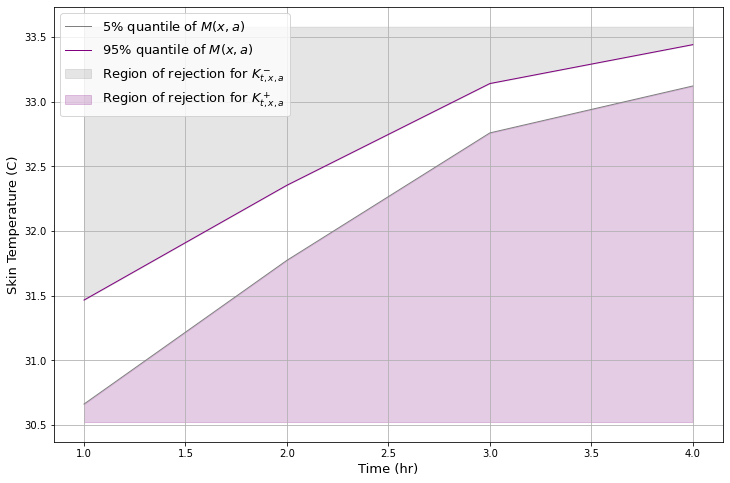

In [213]:
plot_M_quantiles("Temp_C", 1, 2, [3.0, 3.0, 3.0, 3.0], [3, 3, 3, 3])

In [191]:
export_dir = "/data/localhost/taufiq/export-dir/"
MIMICtable = pd.read_csv(export_dir + '/MIMIC-1hourly-length-5-filtered.csv')
MIMICtable_1 = pd.read_csv(export_dir + '/MIMIC-1hourly-length-5-filtered.csv')
MIMIC_generated_males = pd.read_csv(export_dir + '/MIMIC-generated-length-5-gender-0.0.csv')
MIMIC_generated_females = pd.read_csv(export_dir + '/MIMIC-generated-length-5-gender-1.0.csv')
MIMICtable = pd.concat([MIMICtable, MIMIC_generated_males, MIMIC_generated_females], ignore_index=True)
MIMICtable = MIMICtable.sort_values(by=['icustay_id', 'bloc'], ignore_index=True)
age_ranked = rankdata(MIMICtable['age'])/len(MIMICtable)
age_bins = np.floor((age_ranked + 0.2499999999)*4)
median_ages = [MIMICtable.loc[age_bins==1, 'age'].median(), MIMICtable.loc[age_bins==2, 'age'].median(), MIMICtable.loc[age_bins==3, 'age'].median(), MIMICtable.loc[age_bins==4, 'age'].median()]
MIMICtable = MIMICtable.rename(columns={"age": "age_raw"})
MIMICtable['age'] = age_bins


In [192]:
from bareinboim_bounds.Utils import x_columns, get_col_bins
sim_data = pd.DataFrame(columns=x_columns)
col_bins, col_bins_sim = get_col_bins(MIMICtable, MIMICtable.copy(), use_kmeans=True, col_bins_num=5)

In [205]:
def get_data_for_patient_set(gender, age, x_t, actions, t, col_name):
    p_values = pd.read_csv(f"{data_dir}/p_values_{col_name}.csv", converters={'actions': eval, 'x_t': eval, 'M_0.05_quantiles': eval, 'M_0.95_quantiles': eval})
    lower_quantile = p_values.loc[(p_values['gender']==gender) & (p_values['age']==age) & (p_values['actions'].apply(tuple)==tuple(actions)) & (p_values['x_t'].apply(tuple)==tuple(x_t)), 'M_0.05_quantiles'].values[0]
    upper_quantile = p_values.loc[(p_values['gender']==gender) & (p_values['age']==age) & (p_values['actions'].apply(tuple)==tuple(actions)) & (p_values['x_t'].apply(tuple)==tuple(x_t)), 'M_0.95_quantiles'].values[0]
    df0 = MIMICtable.loc[(MIMICtable['gender']==gender) & (MIMICtable['age']==age) & (col_bins==x_t[t]) & (MIMICtable['A']==actions[t])][['gender', 'age_raw'] + x_columns]
    iv_dose = MIMICtable.loc[MIMICtable['A']==actions[t], 'input_1hourly'].median()
    vp_dose = MIMICtable.loc[MIMICtable['A']==actions[t], 'max_dose_vaso'].median()
    df0['age'] = df0['age_raw']/365
    df0.drop(columns=['age_raw'], inplace=True)
    df0_mean = df0.mean(0)
    df0_std = df0.std(0)
    dictionary = {}
    for col in df0_mean.keys():
        if col != 'gender':
            dictionary[col] = str(round(df0_mean[col], 0)) + " ± " + str(round(df0_std[col], 0))
        elif df0_mean[col] == 0:
            dictionary[col] = "male"
        else:
            dictionary[col] = "female"
    dictionary['IV dose'] = iv_dose
    dictionary['VP dose'] = vp_dose
    dictionary = pd.DataFrame(data=dictionary.values(), index=dictionary.keys(), columns=['Values'])
    return dictionary, lower_quantile[t], upper_quantile[t]




In [218]:
data, lq, uq = get_data_for_patient_set(1, 2, [3.0, 3.0, 3.0, 3.0], [3, 3, 3, 3], 1, "Temp_C")

In [217]:
data

,Values
gender,female
Weight_kg,78.0 ± 23.0
paCO2,41.0 ± 10.0
paO2,218.0 ± 136.0
HCO3,1507.0 ± 295.0
Arterial_pH,7.0 ± 0.0
Calcium,86.0 ± 9.0
Chloride,3695.0 ± 197.0
DiaBP,73.0 ± 12.0
Glucose,1458.0 ± 542.0


In [212]:
lq, uq

(46.48247793154621, 49.36951819639027)